In [1]:
from itertools import product
import math
import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator
import numpy as np
from scipy import stats

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

style.use('seaborn-poster') #sets the size of the charts
# style.use('ggplot')

# Useful directory path.
root_dir = f'{os.getcwd()}/../results'
graphics_dir = f'{root_dir}/graphics'

# GP tools.
tools = ('DEAP', 'TensorGP (CPU)', 'TensorGP (GPU)', 'Operon', 'FPGA')

# Function sets.
function_sets = {
    'nicolau_a': (4, 9, 1023, 32),
    'nicolau_b': (6, 7, 255, 8),
    'nicolau_c': (9, 7, 255, 8)
}

# Numbers of fitness cases.
num_fitness_cases = (10, 100, 1000, 10000, 100000)

# Number of programs per size bin.
nppsb = 1024

# Program dictionary.
with open(f'{root_dir}/programs/programs.pkl', 'rb') as f:
    program_dict = pickle.load(f) 

Function counts, bin 0: [2094, 2116, 2037, 2047]
Function counts, bin 1: [6028, 6147, 6161, 6121]
Function counts, bin 2: [10378, 10175, 10199, 10384]
Function counts, bin 3: [14344, 14325, 14216, 14345]
Function counts, bin 4: [18384, 18487, 18349, 18403]
Function counts, bin 5: [22577, 22411, 22609, 22626]
Function counts, bin 6: [26626, 26634, 26619, 26576]
Function counts, bin 7: [30891, 30549, 30574, 30868]
Function counts, bin 8: [34602, 35135, 34919, 34361]
Function counts, bin 9: [38946, 38860, 38823, 39081]
Function counts, bin 10: [42840, 43266, 42995, 42847]
Function counts, bin 11: [47081, 47226, 47260, 47097]
Function counts, bin 12: [51173, 51832, 50668, 51063]
Function counts, bin 13: [55345, 55594, 55141, 55252]
Function counts, bin 14: [59491, 59532, 59198, 59349]
Function counts, bin 15: [63679, 63136, 63512, 63657]
Function counts, bin 16: [67414, 67560, 67868, 67508]
Function counts, bin 17: [71527, 71884, 71656, 71544]
Function counts, bin 18: [75661, 75923, 75852,

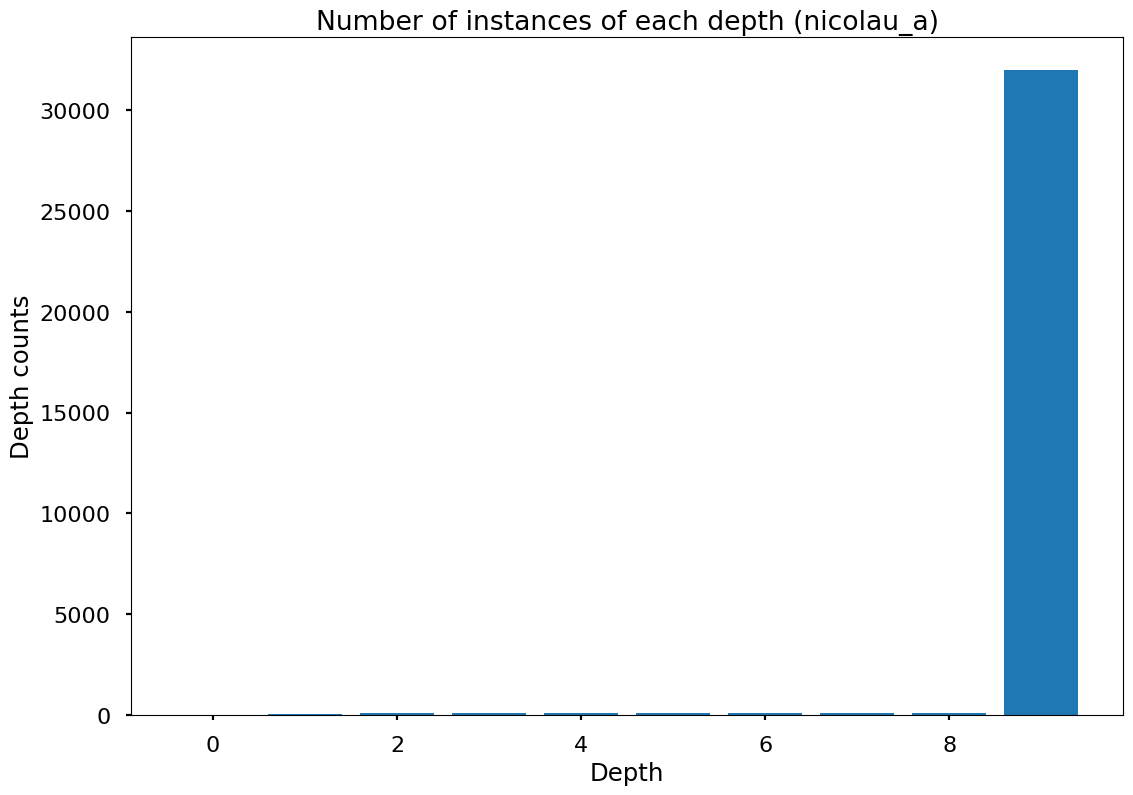

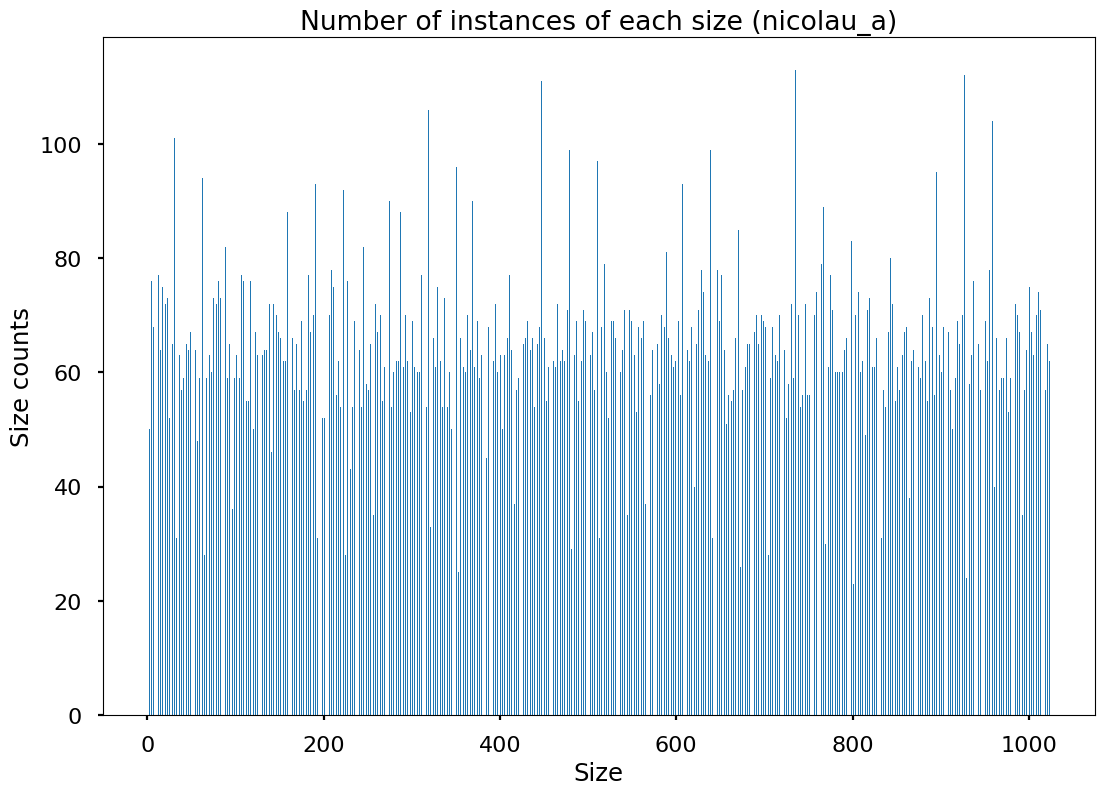

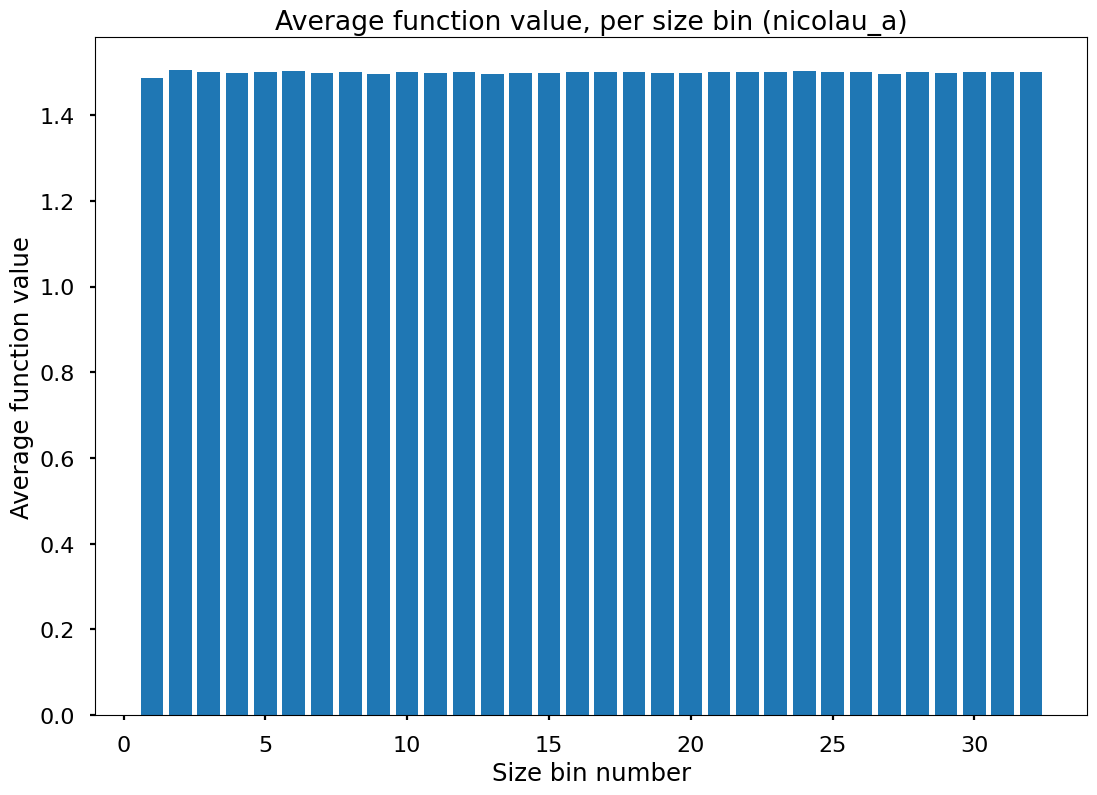

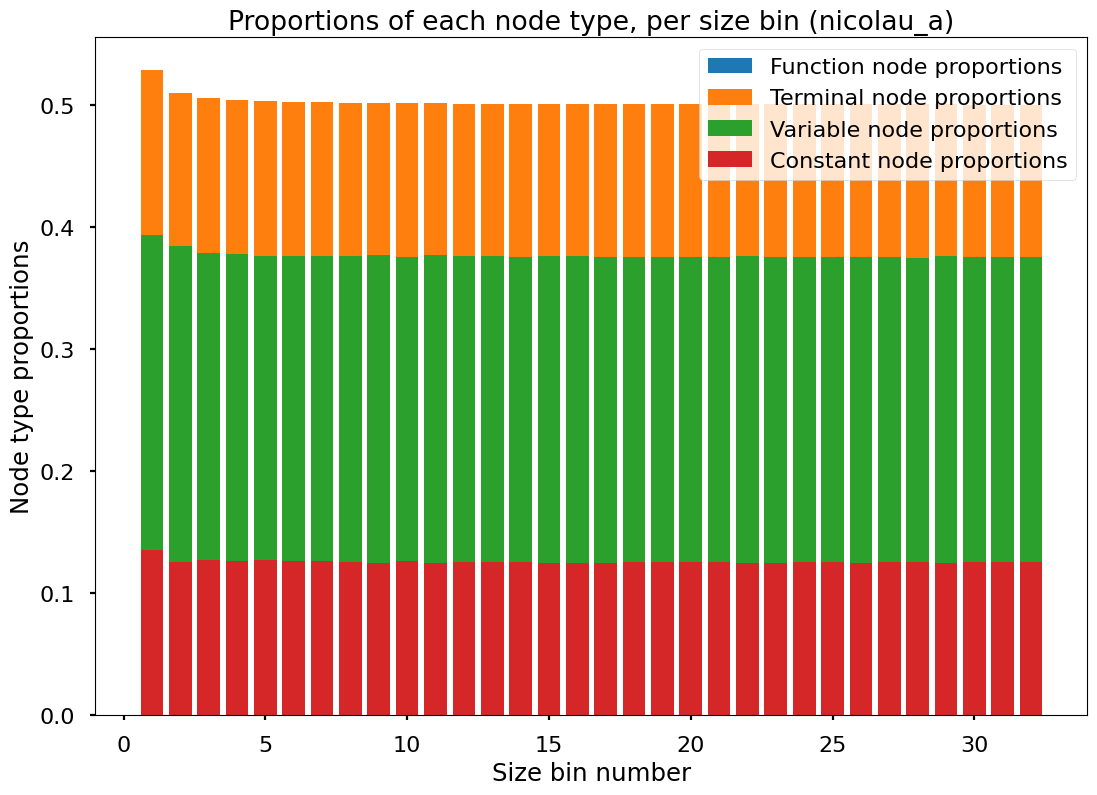

Function counts, bin 0: [527, 527, 498, 448, 485, 448]
Function counts, bin 1: [1236, 1236, 1207, 1160, 1236, 1225]
Function counts, bin 2: [2005, 2006, 2013, 2085, 2083, 1995]
Function counts, bin 3: [2827, 2828, 2853, 2883, 2820, 2874]
Function counts, bin 4: [3653, 3595, 3700, 3559, 3701, 3779]
Function counts, bin 5: [4196, 4214, 4687, 4395, 4547, 4562]
Function counts, bin 6: [4887, 4945, 5373, 5426, 5429, 5403]
Function counts, bin 7: [5424, 5421, 6412, 6296, 6256, 6273]
Function counts, bin 8: [6242, 6105, 7176, 6963, 7181, 7233]
Function counts, bin 9: [6738, 6680, 8025, 8108, 7949, 8061]
Function counts, bin 10: [7002, 7042, 8943, 8885, 9032, 8938]
Function counts, bin 11: [7113, 7278, 9992, 9820, 9924, 10040]
Function counts, bin 12: [7667, 7544, 10748, 10772, 10854, 11066]
Function counts, bin 13: [7502, 7704, 11853, 11764, 11798, 12050]
Function counts, bin 14: [7268, 7194, 12877, 12909, 13037, 13137]
Function counts, bin 15: [6813, 6856, 14110, 14173, 14128, 14026]
Functio

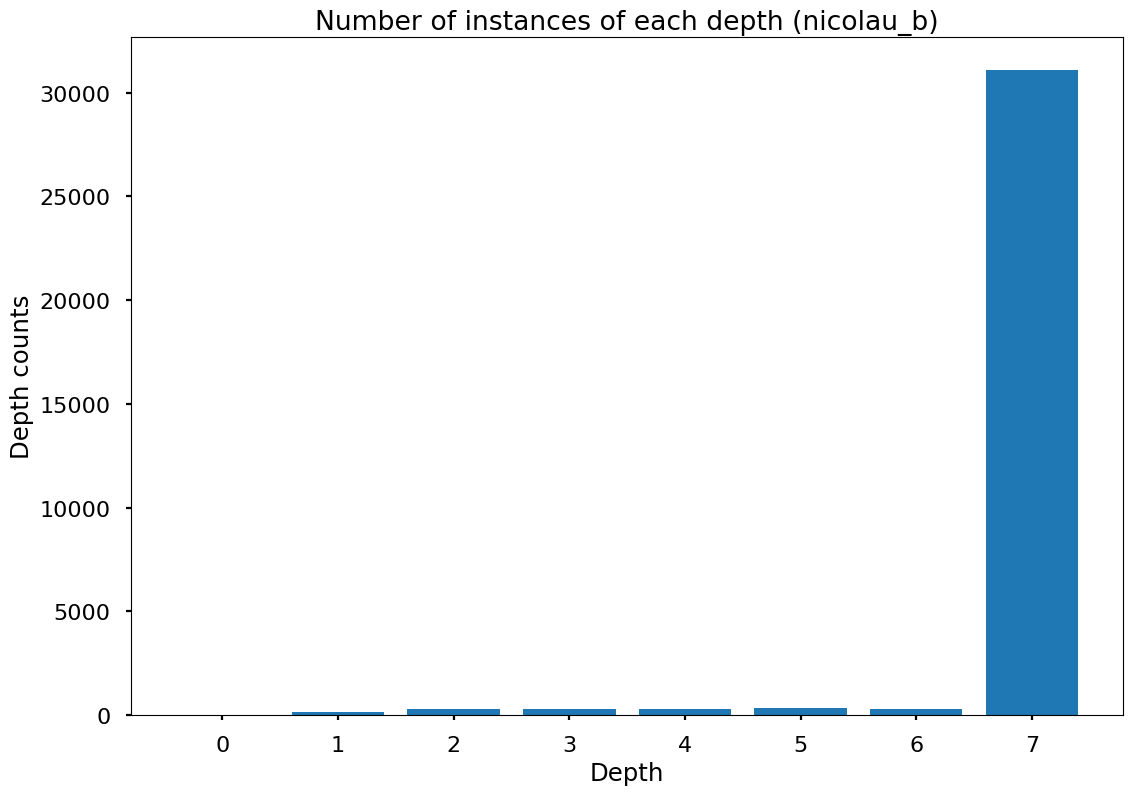

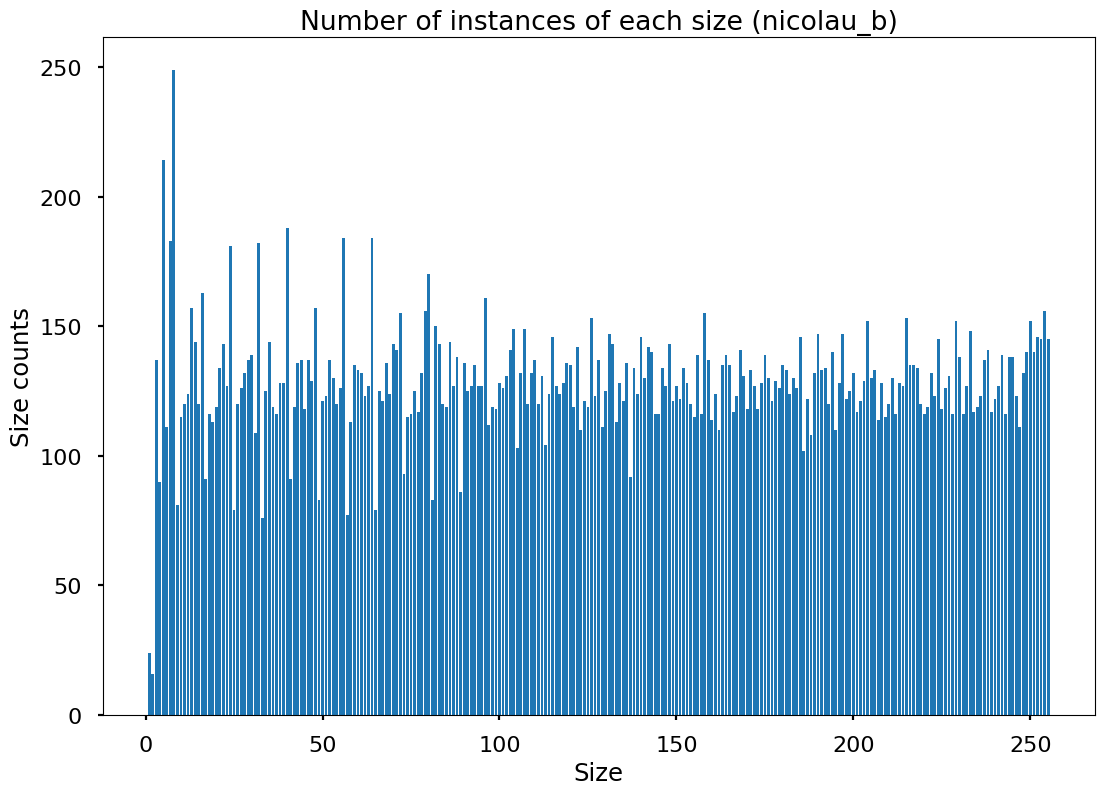

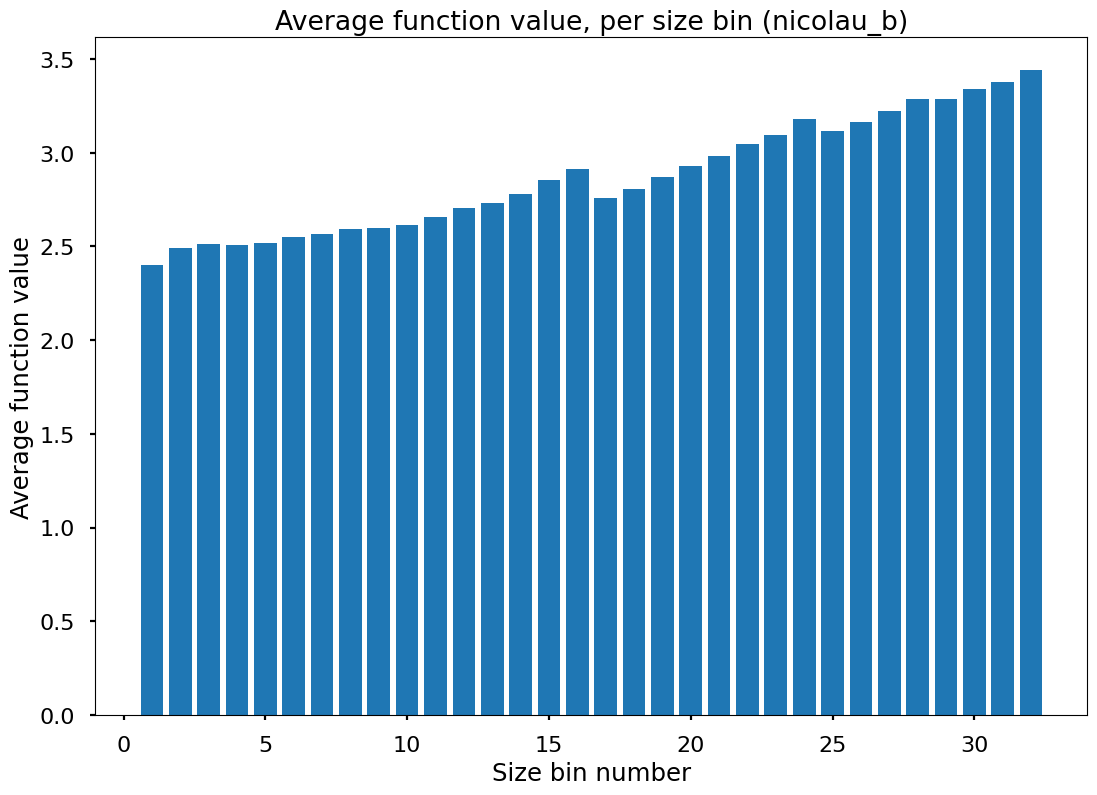

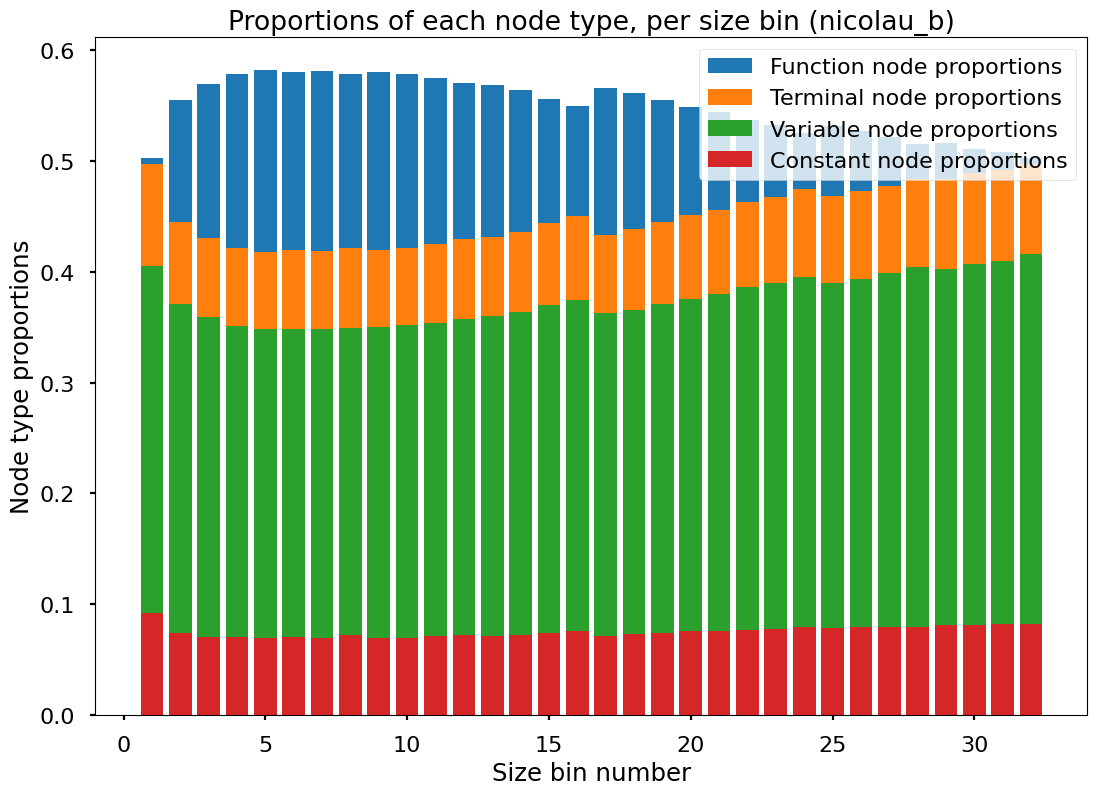

Function counts, bin 0: [391, 373, 336, 325, 341, 330, 348, 359, 351]
Function counts, bin 1: [909, 919, 946, 880, 866, 908, 967, 935, 937]
Function counts, bin 2: [1399, 1413, 1455, 1456, 1471, 1612, 1653, 1657, 1620]
Function counts, bin 3: [1850, 1841, 1908, 1836, 1809, 2435, 2368, 2429, 2338]
Function counts, bin 4: [2254, 2200, 2226, 2243, 2163, 3239, 3225, 3118, 3130]
Function counts, bin 5: [2445, 2450, 2320, 2441, 2434, 4094, 4113, 4065, 4063]
Function counts, bin 6: [2510, 2504, 2551, 2564, 2513, 4994, 5014, 5114, 5001]
Function counts, bin 7: [2647, 2535, 2644, 2570, 2485, 5957, 5910, 6049, 6124]
Function counts, bin 8: [2977, 2949, 3033, 2983, 2981, 6880, 6686, 6864, 6748]
Function counts, bin 9: [2784, 2767, 2793, 2794, 2839, 7887, 7907, 8065, 7845]
Function counts, bin 10: [2736, 2812, 2767, 2755, 2752, 8880, 9170, 9103, 8717]
Function counts, bin 11: [2429, 2415, 2578, 2496, 2473, 10207, 10034, 10099, 10281]
Function counts, bin 12: [2690, 2692, 2702, 2620, 2694, 11140, 1

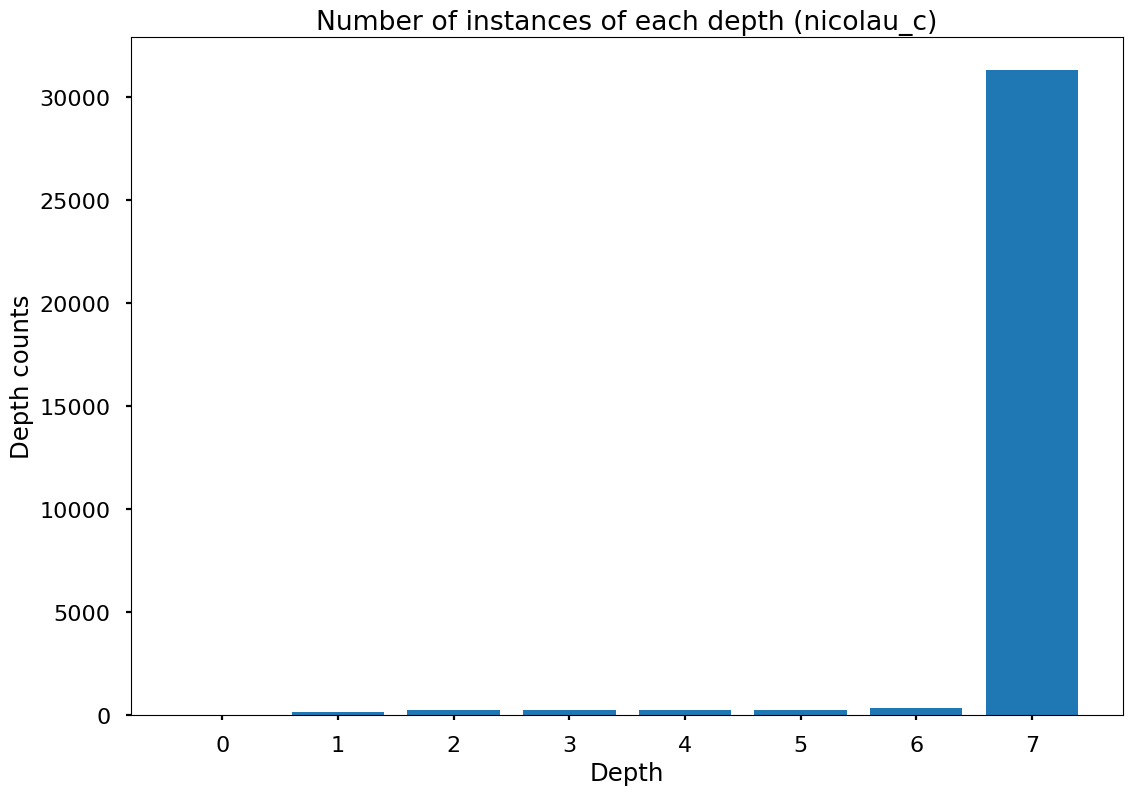

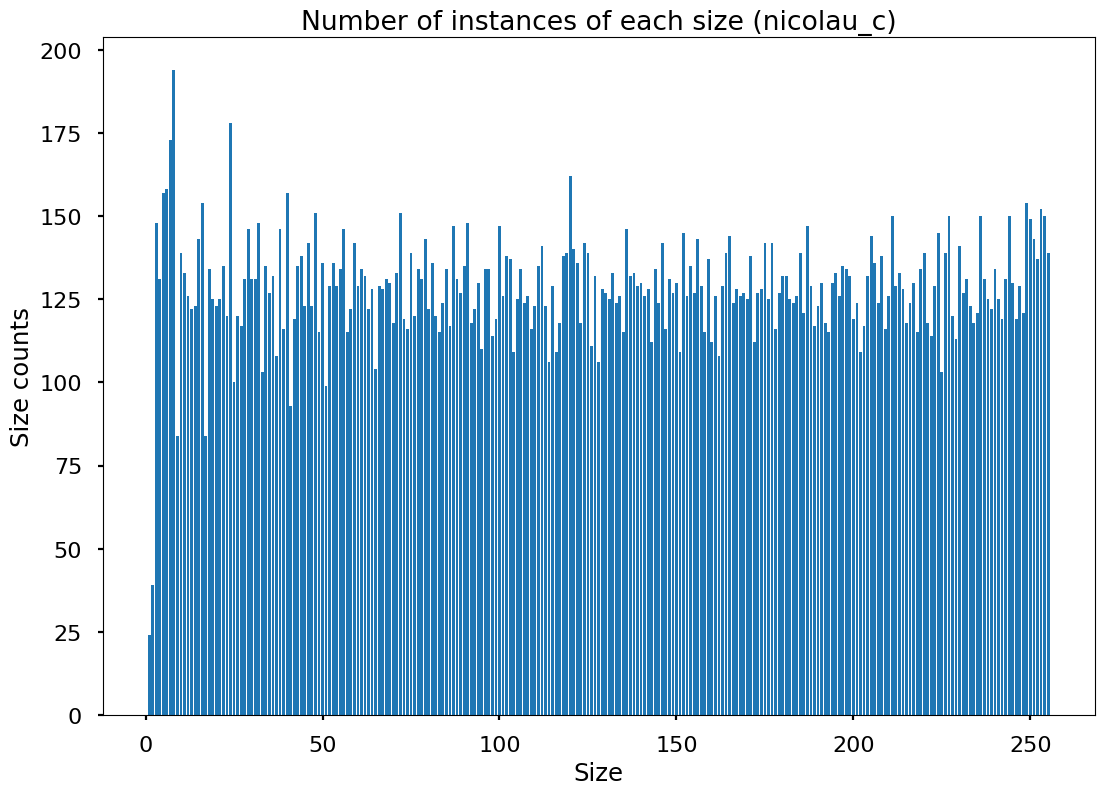

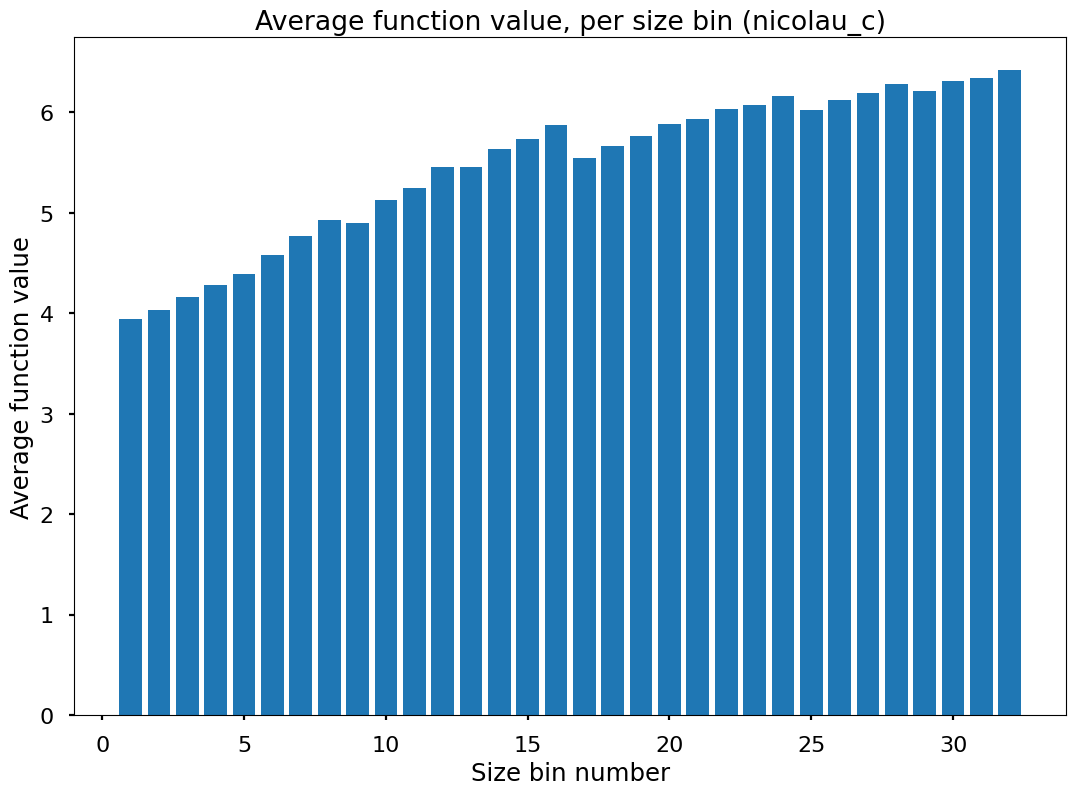

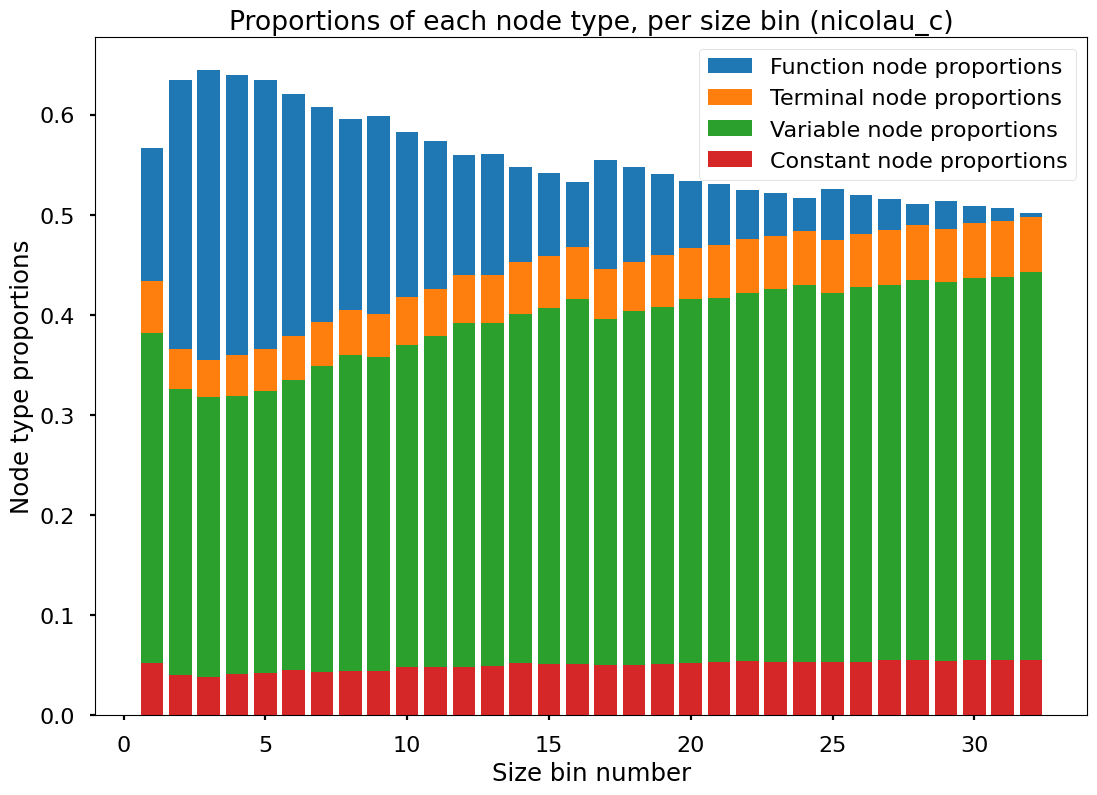

In [2]:
# Compute some statistics for the set of random programs
# generated for each function set.

# Total number of nodes for each size bin, for each function set.
num_nodes = []

for name, (num_functions, max_depth, max_size, bin_size) in (
    function_sets.items()):
    # For each function set...

    # Number of "size bins."
    num_size_bins = int(math.ceil(max_size/bin_size))

    # List where the `i`-th element, `0 <= i <= max_depth`, 
    # is to represent the number of instances for depth `i` 
    # over all random programs (i.e., from all size bins) 
    # for the function set with name `name`.
    depth_counts = [0]*(max_depth+1)

    # List where the `i`-th element, `0 <= i <= max_size-1`, 
    # is to represent the number of instances for size `i+1` 
    # over all random programs (i.e., from all size bins) 
    # for the function set with name `name`.
    size_counts = [0]*(max_size)

    # Lists where the `i`-th element contains the proportion
    # of the total number of nodes for size bin `i` that are 
    # functions/variables/constants/terminals.
    function_node_proportions = []
    variable_node_proportions = []
    constant_node_proportions = []
    terminal_node_proportions = []
    
    # List where the `i`-th element is to represent the 
    # "average function value" for size bin `i`, where 
    # this value is defined here to be the sum of the 
    # numbers of instances of each function type, with 
    # the `i`-th function type (specified by the `function_
    # counts` list) multiplied by `i`, all divided by the 
    # number of function types.
    #
    # In general, if the numbers of instances of function 
    # types are uniformly distributed for each size bin, 
    # the "average function value" as defined above should 
    # be equal to the number of function types minus one,
    # divided by 2. Thus, we can check for such uniformity
    # for each size bin by inspecting such an average value.
    average_function_values = []

    # Prepare for sizes related to the function set.
    num_nodes.append([])

    # Results of chi-square tests for each bin of the function set.
    chi_square = [[]]

    # Compute the relevant list elements.
    for i, (programs, depths, sizes, function_counts, 
        variable_counts, constant_counts) in enumerate(program_dict[name]
            [0:num_size_bins]):

        for depth in depths: depth_counts[depth] += 1
        for size in sizes: size_counts[size-1] += 1

        function_node_sum = sum(function_counts)
        variable_node_sum = sum(variable_counts)
        constant_node_sum = sum(constant_counts)
        terminal_node_sum = variable_node_sum + constant_node_sum
        node_sum = function_node_sum + terminal_node_sum

        function_node_proportions.append(function_node_sum/node_sum)
        variable_node_proportions.append(variable_node_sum/node_sum)
        constant_node_proportions.append(constant_node_sum/node_sum)
        terminal_node_proportions.append(terminal_node_sum/node_sum)
 
        average_function_value = (0) if (function_node_sum == 0) else (
            sum([i*function_counts[i] for i in range(
                num_functions)])/function_node_sum)

        average_function_values.append(average_function_value)

        # Add total number of nodes for the current size bin.
        num_nodes[-1].append(sum(sizes))

        # P-value for one-way chi-square test, performed for 
        # each set of function counts.
        _, p = stats.chisquare(function_counts)
        chi_square[-1].append(p)

        print(f'Function counts, bin {i}: {function_counts}')

    print(f'Chi-square p-values: {chi_square[-1]}')
    print(f'Minimum chi-square p-value: {min(chi_square[-1])}')
    print(f'Average chi-square p-value: {np.mean(chi_square[-1])}')

    # Compute/plot some relevant statistics for the number 
    # of instances of each possible program depth.

    # print('Program depths: ', depth_counts)
    # print('Mean of depth counts: ', np.mean(depth_counts))
    # print('Variance of depth counts: ', np.var(depth_counts))
    # print('Standard deviation of depth counts: ', np.std(depth_counts))
    # print(stats.chisquare(depth_counts))

    # Plot bar graph of depth counts.
    index = range(0, max_depth+1)
    plt.bar(index, depth_counts)
    plt.xlabel('Depth')
    plt.ylabel('Depth counts')
    plt.title('Number of instances of each depth ('+name+')')
    plt.savefig(f'{graphics_dir}/{name}/depths.svg')
    plt.show()


    # Compute/plot some relevant statistics for the number 
    # of instances of each possible program size.

    # print('Program sizes: ', size_counts)
    # print('Mean of size counts: ', np.mean(size_counts))
    # print('Variance of size counts: ', np.var(size_counts))
    # print('Standard deviation of size counts: ', np.std(size_counts))
    # print(stats.chisquare(size_counts))

    # Plot bar graph of size counts.
    index = range(1, max_size+1)
    plt.bar(index, size_counts)
    plt.xlabel('Size')
    plt.ylabel('Size counts')
    plt.title('Number of instances of each size ('+name+')')
    plt.savefig(f'{graphics_dir}/{name}/sizes.svg')
    plt.show()


    # Compute/plot some relevant statistics for the average
    # function values.

    # print('Average function values: ', average_function_values)
    # print('Mean of average function values: ', 
    #     np.mean(average_function_values))
    # print('Variance of average function values: ', 
    #     np.var(average_function_values))
    # print('Standard deviation of average function values: ', 
    #     np.std(average_function_values))
    # print(f'\n\nAverage function values: {average_function_values}\n\n')
    # print(stats.chisquare(average_function_values))

    # Plot bar graph of average function values.
    index = range(1, num_size_bins+1)

    #log_approx = [4*(1/log(max_size,2))*log(max_size/x,2) + 
    #    10.5*(1/log(max_size,2))*log(x, 2) for x in index]

    #plt.plot(index, log_approx)
    plt.bar(index, average_function_values)

    plt.xlabel('Size bin number')
    plt.ylabel('Average function value')
    plt.title('Average function value, per size bin ('+name+')')
    plt.savefig(f'{graphics_dir}/{name}/average_function_values.svg')
    plt.show()


    # Compute/plot some relevant statistics for proportions
    # of the total number of nodes with particular node types.

    # print('Function node proportions: ', function_node_proportions)
    # print('Terminal node proportions: ', terminal_node_proportions)
    # print('Variable node proportions: ', variable_node_proportions)
    # print('Constant node proportions: ', constant_node_proportions)


    # Plot bar graph of function counts.
    index = range(1, num_size_bins+1)
    plt.bar(index, function_node_proportions, 
        label='Function node proportions')
    plt.bar(index, terminal_node_proportions, 
        label='Terminal node proportions')
    plt.bar(index, variable_node_proportions, 
        label='Variable node proportions')
    plt.bar(index, constant_node_proportions, 
        label='Constant node proportions')
    plt.xlabel('Size bin number')
    plt.ylabel('Node type proportions')
    plt.title('Proportions of each node type, per size bin ('+name+')')
    plt.legend(loc='upper right')
    plt.savefig(f'{graphics_dir}/{name}/node_proportions.svg')
    plt.show()

In [3]:
# Average of *median average runtimes* for each size bin,
# for each number of fitness cases, for each function set,
# for each tool.
avg_med_avg_runtimes = []

# Median of *median average runtimes* for each size bin,
# for each number of fitness cases, for each function set,
# for each tool.
med_med_avg_runtimes = []

# Minimum of *median average runtimes* for each size bin,
# for each number of fitness cases, for each function set,
# for each tool.
min_med_avg_runtimes = []

# Maximum of *median average runtimes* for each size bin,
# for each number of fitness cases, for each function set,
# for each tool.
max_med_avg_runtimes = []

# Standard deviation of *median average runtimes* for each size 
# bin, for each number of fitness cases, for each function set,
# for each tool.
std_dev_med_avg_runtimes = []

# Interquartile range of *median average runtimes* for each size 
# bin, for each number of fitness cases, for each function set,
# for each tool.
iqr_med_avg_runtimes = []

# Median node evaluations per second (NEPS) from *median average
# runtimes* for each size bin, for each number of fitness cases, 
# for each function set, for each tool.
med_neps = []

# Median of median node evaluations per second (NEPS) for each 
# size bin, for each number of fitness cases, for each function 
# set, for each tool.
med_med_neps = []

# Interquartile range of median node evaluations per second (NEPS) 
# for each size bin, for each number of fitness cases, for each 
# function set, for each tool.
iqr_med_neps = []

In [4]:
####################################################################

# Compute statistics for DEAP.

with open(f'{root_dir}/results_deap.pkl', 'rb') as f:
    _, med_avg_runtimes = pickle.load(f)

# Prepare for statistics related to the tool.
avg_med_avg_runtimes.append([])
med_med_avg_runtimes.append([])
min_med_avg_runtimes.append([])
max_med_avg_runtimes.append([])
std_dev_med_avg_runtimes.append([])
iqr_med_avg_runtimes.append([])
med_neps.append([])
med_med_neps.append([])
iqr_med_neps.append([])

for i, (name, (num_functions, max_depth, max_size, bin_size)) in enumerate(
    function_sets.items()):
    # For each function set...
    print(f'For function set `{name}`...')

    # Number of "size bins."
    num_size_bins = int(math.ceil(max_size/bin_size))

    # Prepare for statistics related to the function set.
    avg_med_avg_runtimes[-1].append([])
    med_med_avg_runtimes[-1].append([])
    min_med_avg_runtimes[-1].append([])
    max_med_avg_runtimes[-1].append([])
    std_dev_med_avg_runtimes[-1].append([])
    iqr_med_avg_runtimes[-1].append([])
    med_neps[-1].append([])
    med_med_neps[-1].append([])
    iqr_med_neps[-1].append([])

    for j, nfc in enumerate(num_fitness_cases):
        # For each number of fitness cases...
        print(f'For number of fitness cases `{nfc}`...')

        # Average of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        avg_med_avg_runtimes[-1][-1].append(
            [np.mean(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Averages of median average runtimes:', 
            avg_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Median of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        med_med_avg_runtimes[-1][-1].append(
            [np.median(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Medians of median average runtimes:', 
            med_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Minimum of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        min_med_avg_runtimes[-1][-1].append(
            [min(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Minimums of median average runtimes:', 
            min_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Maximum of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        max_med_avg_runtimes[-1][-1].append(
            [max(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Maximums of median average runtimes:', 
            max_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Standard deviation of *median average runtimes* for each 
        # size bin, relevant to the number of fitness cases.
        std_dev_med_avg_runtimes[-1][-1].append(
            [np.std(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Standard deviations of median average runtimes:', 
            std_dev_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Interquartile range of *median average runtimes* for each 
        # size bin, relevant to the number of fitness cases.
        iqr_med_avg_runtimes[-1][-1].append(
            [stats.iqr(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Interquartile range of median average runtimes:', 
            iqr_med_avg_runtimes[-1][-1][-1])
        print('\n\n')

        print('Number of nodes per size bin:', num_nodes[i])

        # Number of node evaluations per size bin.
        num_evals = [(n * nfc) for n in num_nodes[i]]

        print('Number of node evaluations per size bin:', num_evals)

        # Median node evaluations per second (NEPS) from *median 
        # average runtimes*, for each size bin, relevant to the 
        # number of fitness cases.
        med_neps[-1][-1].append([[num_evals_ / med_avg_runtime
            for med_avg_runtime in med_avg_runtimes[i][j][k]]
            for k, num_evals_ in enumerate(num_evals)])
        print('Median node evaluations per second:', med_neps[-1][-1][-1])
        print('\n')

        # Median node evaluations per second (NEPS) of *median 
        # average runtimes*, for each size bin, relevant to the 
        # number of fitness cases.
        med_med_neps[-1][-1].append([np.median(med_neps_)
            for med_neps_ in med_neps[-1][-1][-1]])
        print('Median of median node evaluations per second:', 
            med_med_neps[-1][-1][-1])
        print('\n')

        # Interquartile range of median node evaluations per second 
        # (NEPS), for each size bin, relevant to the number of fitness 
        # cases.
        iqr_med_neps[-1][-1].append([stats.iqr(med_neps_)
            for med_neps_ in med_neps[-1][-1][-1]])
        print('Interquartile range of median node evaluations per second:', 
            iqr_med_neps[-1][-1][-1])
        print('\n')

        # Minimum median NEPS value.
        print('Minimum median NEPS value', min(med_med_neps[-1][-1][-1]))

        # Maximum median NEPS value.
        print('Maximum median NEPS value', max(med_med_neps[-1][-1][-1]))

For function set `nicolau_a`...
For number of fitness cases `10`...
Averages of median average runtimes: [0.6168124930045451, 0.8574048579976079, 1.1486058949958533, 1.3313706720000482, 1.5975089970015688, 1.9105711480005994, 2.2113706639938755, 2.439378814997326, 2.632915539004898, 2.949005633003253, 3.2472865200033993, 3.469258962002641, 3.767213958002685, 4.080000441004813, 4.094597713999974, 4.538547746000404, 4.752753761000349, 4.9152218119998, 5.176315509001142, 5.544410318994778, 5.769049031994655, 5.884782697001356, 6.405918128999474, 6.47231715000089, 6.787591648004309, 6.920449419005308, 7.104686639999272, 7.5798249450017465, 7.834793198002444, 8.13533450599789, 8.322470229999453, 8.609733853998478]


Medians of median average runtimes: [0.6168124930045451, 0.8574048579976079, 1.1486058949958533, 1.3313706720000482, 1.5975089970015688, 1.9105711480005994, 2.2113706639938755, 2.439378814997326, 2.632915539004898, 2.949005633003253, 3.2472865200033993, 3.469258962002641, 3.7672

In [5]:
####################################################################

# Compute statistics for TensorGP.

with open(f'{root_dir}/results_tensorgp.pkl', 'rb') as f:
    med_avg_runtimes = pickle.load(f)

for i, device in enumerate(('CPU', 'GPU')):
    # For each device...
    print(f'For device `{device}`...')

    # Prepare for statistics related to the tool.
    avg_med_avg_runtimes.append([])
    med_med_avg_runtimes.append([])
    min_med_avg_runtimes.append([])
    max_med_avg_runtimes.append([])
    std_dev_med_avg_runtimes.append([])
    iqr_med_avg_runtimes.append([])
    med_neps.append([])
    med_med_neps.append([])
    iqr_med_neps.append([])

    for j, (name, (num_functions, max_depth, max_size, bin_size)) in enumerate(
        function_sets.items()):
        # For each function set...
        print(f'For function set `{name}`...')

        # Number of "size bins."
        num_size_bins = int(math.ceil(max_size/bin_size))

        # Prepare for statistics related to the function set.
        avg_med_avg_runtimes[-1].append([])
        med_med_avg_runtimes[-1].append([])
        min_med_avg_runtimes[-1].append([])
        max_med_avg_runtimes[-1].append([])
        std_dev_med_avg_runtimes[-1].append([])
        iqr_med_avg_runtimes[-1].append([])
        med_neps[-1].append([])
        med_med_neps[-1].append([])
        iqr_med_neps[-1].append([])

        for k, nfc in enumerate(num_fitness_cases):
            # For each number of fitness cases...
            print(f'For number of fitness cases `{nfc}`...')


            # Average of *median average runtimes* for each size bin,
            # relevant to the number of fitness cases.
            avg_med_avg_runtimes[-1][-1].append(
                [np.mean(med_avg_runtimes[i][j][k][m]) 
                for m in range(num_size_bins)])
            print('Averages of median average runtimes:', 
                avg_med_avg_runtimes[-1][-1][-1])
            print('\n')

            # Median of *median average runtimes* for each size bin,
            # relevant to the number of fitness cases.
            med_med_avg_runtimes[-1][-1].append(
                [np.median(med_avg_runtimes[i][j][k][m]) 
                for m in range(num_size_bins)])
            print('Medians of median average runtimes:', 
                med_med_avg_runtimes[-1][-1][-1])
            print('\n')

            # Minimum of *median average runtimes* for each size bin,
            # relevant to the number of fitness cases.
            min_med_avg_runtimes[-1][-1].append(
                [min(med_avg_runtimes[i][j][k][m]) 
                for m in range(num_size_bins)])
            print('Minimums of median average runtimes:', 
                min_med_avg_runtimes[-1][-1][-1])
            print('\n')

            # Maximum of *median average runtimes* for each size bin,
            # relevant to the number of fitness cases.
            max_med_avg_runtimes[-1][-1].append(
                [max(med_avg_runtimes[i][j][k][m]) 
                for m in range(num_size_bins)])
            print('Maximums of median average runtimes:', 
                max_med_avg_runtimes[-1][-1][-1])
            print('\n')

            # Standard deviation of *median average runtimes* for each size bin,
            # relevant to the number of fitness cases.
            std_dev_med_avg_runtimes[-1][-1].append(
                [np.std(med_avg_runtimes[i][j][k][m]) 
                for m in range(num_size_bins)])
            print('Standard deviations of median average runtimes:', 
                std_dev_med_avg_runtimes[-1][-1][-1])
            print('\n')

            # Interquartile range of *median average runtimes* for each size bin,
            # relevant to the number of fitness cases.
            iqr_med_avg_runtimes[-1][-1].append(
                [stats.iqr(med_avg_runtimes[i][j][k][m]) 
                for m in range(num_size_bins)])
            print('Interquartile range of median average runtimes:', 
                iqr_med_avg_runtimes[-1][-1][-1])
            print('\n\n')

            print('Number of nodes per size bin:', num_nodes[j])

            # Number of node evaluations per size bin.
            num_evals = [(n * nfc) for n in num_nodes[j]]

            print('Number of node evaluations per size bin:', num_evals)

            # Median node evaluations per second (NEPS) from *median 
            # average runtimes*, for each size bin, relevant to the 
            # number of fitness cases.
            med_neps[-1][-1].append([[num_evals_ / med_avg_runtime
                for med_avg_runtime in med_avg_runtimes[i][j][k][m]]
                for m, num_evals_ in enumerate(num_evals)])
            print('Median node evaluations per second:', 
                med_neps[-1][-1][-1])
            print('\n')

            # Median node evaluations per second (NEPS) of *median 
            # average runtimes*, for each size bin, relevant to the 
            # number of fitness cases.
            med_med_neps[-1][-1].append([np.median(med_neps_) 
                for med_neps_ in med_neps[-1][-1][-1]])
            print('Median of median node evaluations per second:', 
                med_med_neps[-1][-1][-1])
            print('\n')

            # Interquartile range of median node evaluations per 
            # second (NEPS), for each size bin, relevant to the number 
            # of fitness cases.
            iqr_med_neps[-1][-1].append([stats.iqr(med_neps_) 
                for med_neps_ in med_neps[-1][-1][-1]])
            print('Interquartile range of median node evaluations per second:', 
                iqr_med_neps[-1][-1][-1])
            print('\n')

For device `CPU`...
For function set `nicolau_a`...
For number of fitness cases `10`...
Averages of median average runtimes: [0.21379514038562775, 0.3085016757249832, 0.42068129032850266, 0.5541958659887314, 0.6864648759365082, 0.8061537072062492, 0.9347267970442772, 1.0761804208159447, 1.2137140557169914, 1.3319992199540138, 1.4723706617951393, 1.5795884355902672, 1.720471665263176, 1.867715798318386, 1.971467100083828, 2.119371213018894, 2.2575642243027687, 2.3781188502907753, 2.488134518265724, 2.625434823334217, 2.7395448982715607, 2.8899834752082825, 3.0208629444241524, 3.1444182991981506, 3.2685513123869896, 3.3865694105625153, 3.5458945259451866, 3.6758972331881523, 3.835698187351227, 3.9157165214419365, 4.034362129867077, 4.151477865874767]


Medians of median average runtimes: [0.21379514038562775, 0.3085016757249832, 0.42068129032850266, 0.5541958659887314, 0.6864648759365082, 0.8061537072062492, 0.9347267970442772, 1.0761804208159447, 1.2137140557169914, 1.3319992199540138, 

In [6]:
####################################################################

# Compute statistics for Operon.

# Read in the median average runtime results from some 
# CSV files, and convert into another useful format.
med_avg_runtimes = []

for name, (num_functions, max_depth, 
        max_size, bin_size) in function_sets.items():
    
    # Number of "size bins."
    num_size_bins = int(math.ceil(max_size/bin_size))

    # Prepare for statistics relevant to the function set.
    med_avg_runtimes.append([])

    with open(f'{root_dir}/results_operon_{name}.csv', 'r') as f:
        lines = f.readlines()

    for nfc in num_fitness_cases:
        # Prepare for statistics relevant to the number
        # of fitness cases.
        med_avg_runtimes[-1].append([[] for _ in range(num_size_bins)])

        # Offset into the lines list.
        i = (int(math.log(nfc, 10)) - 1) * num_size_bins

        for j in range(1, num_size_bins + 1):
            # Number of decimal digits needed to represent `j`.
            d = int(math.ceil(math.log(j + 1, 10)))

            # String representing median average runtimes
            # for bin `j`, in terms of microseconds.
            runtimes_str = ''.join(lines[i+j-1].split())[(5+d):]

            # Median average runtimes for bin `j`, in terms
            # of seconds.
            runtimes = [float(t)/(10**6) for t in runtimes_str.split(',')]

            med_avg_runtimes[-1][-1][j-1] = runtimes

# Prepare for statistics related to the tool.
avg_med_avg_runtimes.append([])
med_med_avg_runtimes.append([])
min_med_avg_runtimes.append([])
max_med_avg_runtimes.append([])
std_dev_med_avg_runtimes.append([])
iqr_med_avg_runtimes.append([])
med_neps.append([])
med_med_neps.append([])
iqr_med_neps.append([])

for i, (name, (num_functions, max_depth, max_size, bin_size)) in enumerate(
    function_sets.items()):
    # For each function set...
    print(f'For function set `{name}`...')

    # Number of "size bins."
    num_size_bins = int(math.ceil(max_size/bin_size))

    # Prepare for statistics related to the function set.
    avg_med_avg_runtimes[-1].append([])
    med_med_avg_runtimes[-1].append([])
    min_med_avg_runtimes[-1].append([])
    max_med_avg_runtimes[-1].append([])
    std_dev_med_avg_runtimes[-1].append([])
    iqr_med_avg_runtimes[-1].append([])
    med_neps[-1].append([])
    med_med_neps[-1].append([])
    iqr_med_neps[-1].append([])

    for j, nfc in enumerate(num_fitness_cases):
        # For each number of fitness cases...
        print(f'For number of fitness cases `{nfc}`...')

        # Average of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        avg_med_avg_runtimes[-1][-1].append(
            [np.mean(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Averages of median average runtimes:', 
            avg_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Median of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        med_med_avg_runtimes[-1][-1].append(
            [np.median(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Medians of median average runtimes:', 
            med_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Minimum of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        min_med_avg_runtimes[-1][-1].append(
            [min(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Minimums of median average runtimes:', 
            min_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Maximum of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        max_med_avg_runtimes[-1][-1].append(
            [max(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Maximums of median average runtimes:', 
            max_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Standard deviation of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        std_dev_med_avg_runtimes[-1][-1].append(
            [np.std(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Standard deviations of median average runtimes:', 
            std_dev_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Interquartile range of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        iqr_med_avg_runtimes[-1][-1].append(
            [stats.iqr(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Interquartile range of median average runtimes:', 
            iqr_med_avg_runtimes[-1][-1][-1])
        print('\n\n')

        print('Number of nodes per size bin:', num_nodes[i])

        # Number of node evaluations per size bin.
        num_evals = [(n * nfc) for n in num_nodes[i]]

        print('Number of node evaluations per size bin:', num_evals)

        # Median node evaluations per second (NEPS) from *median 
        # average runtimes*, for each size bin, relevant to the 
        # number of fitness cases.
        med_neps[-1][-1].append([[num_evals_ / med_avg_runtime
            for med_avg_runtime in med_avg_runtimes[i][j][k]]
            for k, num_evals_ in enumerate(num_evals)])
        print('Median node evaluations per second:', med_neps[-1][-1][-1])
        print('\n')

        # Median node evaluations per second (NEPS) of *median 
        # average runtimes*, for each size bin, relevant to the 
        # number of fitness cases.
        med_med_neps[-1][-1].append([np.median(med_neps_)
            for med_neps_ in med_neps[-1][-1][-1]])
        print('Median of median node evaluations per second:', 
            med_med_neps[-1][-1][-1])
        print('\n')

        # Interquartile range of median node evaluations per second 
        # (NEPS), for each size bin, relevant to the number of fitness 
        # cases.
        iqr_med_neps[-1][-1].append([stats.iqr(med_neps_)
            for med_neps_ in med_neps[-1][-1][-1]])
        print('Interquartile range of median node evaluations per second:', 
            iqr_med_neps[-1][-1][-1])
        print('\n')

        # Minimum median NEPS value.
        print('Minimum median NEPS value', min(med_med_neps[-1][-1][-1]))

        # Maximum median NEPS value.
        print('Maximum median NEPS value', max(med_med_neps[-1][-1][-1]))

For function set `nicolau_a`...
For number of fitness cases `10`...
Averages of median average runtimes: [0.0030526204545454553, 0.0030156019999999996, 0.0015886762727272726, 0.001036531909090909, 0.001039159, 0.0009817158181818183, 0.001172023909090909, 0.0012578199999999998, 0.0011314585454545454, 0.0009567699999999999, 0.0012916526363636364, 0.001605588181818182, 0.0020400601818181814, 0.0014197229090909093, 0.0023124474545454547, 0.0017466086363636365, 0.0019811974545454547, 0.0022617142727272724, 0.0031946772727272726, 0.002478677272727273, 0.0020783968181818185, 0.0018604037272727273, 0.002916397, 0.0028184550909090907, 0.0023301853636363635, 0.0023428357272727274, 0.0036720497272727274, 0.002636117090909091, 0.004279467818181818, 0.002963172636363636, 0.003004131636363636, 0.0029350091818181813]


Medians of median average runtimes: [0.002564513, 0.001764928, 0.000768658, 0.000784159, 0.001037238, 0.000915248, 0.0011062090000000001, 0.0012372840000000002, 0.000977097, 0.00100948

In [7]:
####################################################################

# Compute statistics for FPGA.

# Runtimes for FPGA.
runtimes = []

for name, (num_functions, max_depth, 
        max_size, bin_size) in function_sets.items():
    
    # Number of "size bins."
    num_size_bins = int(math.ceil(max_size/bin_size))

    # Prepare for statistics relevant to the function set.
    runtimes.append([])

    for nfc in num_fitness_cases:
        with open(f'{root_dir}/performance_counts/{name}/{nfc}.txt', 'r') as f:
            # Lines of the current file.
            lines = f.readlines()

            # Clock frequency for specified run.
            clock_freq = float(lines[0])*1e6

            # Runtimes relevant to the number of fitness cases.
            runtimes[-1].append([[float(lines[i])/clock_freq] 
                for i in range(1, num_size_bins+1)])

# Prepare for statistics related to the tool.
avg_med_avg_runtimes.append([])
med_med_avg_runtimes.append([])
min_med_avg_runtimes.append([])
max_med_avg_runtimes.append([])
std_dev_med_avg_runtimes.append([])
iqr_med_avg_runtimes.append([])
med_neps.append([])
med_med_neps.append([])
iqr_med_neps.append([])

for i, (name, (num_functions, max_depth, max_size, bin_size)) in enumerate(
    function_sets.items()):
    # For each function set...
    print(f'For function set `{name}`...')

    # Number of "size bins."
    num_size_bins = int(math.ceil(max_size/bin_size))

    # Prepare for statistics related to the function set.
    avg_med_avg_runtimes[-1].append([])
    med_med_avg_runtimes[-1].append([])
    min_med_avg_runtimes[-1].append([])
    max_med_avg_runtimes[-1].append([])
    std_dev_med_avg_runtimes[-1].append([])
    iqr_med_avg_runtimes[-1].append([])
    med_neps[-1].append([])
    med_med_neps[-1].append([])
    iqr_med_neps[-1].append([])

    for j, nfc in enumerate(num_fitness_cases):
        # For each number of fitness cases...
        print(f'For number of fitness cases `{nfc}`...')

        # Average of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        avg_med_avg_runtimes[-1][-1].append(
            [np.mean(runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Averages of median average runtimes:', 
            avg_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Median of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        med_med_avg_runtimes[-1][-1].append(
            [np.median(runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Medians of median average runtimes:', 
            med_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Minimum of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        min_med_avg_runtimes[-1][-1].append(
            [min(runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Minimums of median average runtimes:', 
            min_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Maximum of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        max_med_avg_runtimes[-1][-1].append(
            [max(runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Maximums of median average runtimes:', 
            max_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Standard deviation of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        std_dev_med_avg_runtimes[-1][-1].append(
            [np.std(runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Standard deviations of median average runtimes:', 
            std_dev_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Interquartile range of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        iqr_med_avg_runtimes[-1][-1].append(
            [stats.iqr(runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Interquartile range of median average runtimes:', 
            iqr_med_avg_runtimes[-1][-1][-1])
        print('\n\n')

        print('Number of nodes per size bin:', num_nodes[i])

        # Number of node evaluations per size bin.
        num_evals = [(n * nfc) for n in num_nodes[i]]

        print('Number of node evaluations per size bin:', num_evals)

        # Median node evaluations per second (NEPS) from *median 
        # average runtimes*, for each size bin, relevant to the 
        # number of fitness cases.
        med_neps[-1][-1].append([[num_evals_ / runtime
            for runtime in runtimes[i][j][k]]
            for k, num_evals_ in enumerate(num_evals)])
        print('Median node evaluations per second:', med_neps[-1][-1][-1])
        print('\n')

        # Median node evaluations per second (NEPS) of *median 
        # average runtimes*, for each size bin, relevant to the 
        # number of fitness cases.
        med_med_neps[-1][-1].append([np.median(med_neps_)
            for med_neps_ in med_neps[-1][-1][-1]])
        print('Median of median node evaluations per second:', 
            med_med_neps[-1][-1][-1])
        print('\n')

        # Interquartile range of median node evaluations per second 
        # (NEPS), for each size bin, relevant to the number of fitness 
        # cases.
        iqr_med_neps[-1][-1].append([stats.iqr(med_neps_)
            for med_neps_ in med_neps[-1][-1][-1]])
        print('Interquartile range of median node evaluations per second:', 
            iqr_med_neps[-1][-1][-1])
        print('\n')

        # Minimum median NEPS value.
        print('Minimum median NEPS value', min(med_med_neps[-1][-1][-1]))

        # Maximum median NEPS value.
        print('Maximum median NEPS value', max(med_med_neps[-1][-1][-1]))

For function set `nicolau_a`...
For number of fitness cases `10`...
Averages of median average runtimes: [2.9117826861228503e-05, 6.205866978532636e-05, 9.074679495698554e-05, 0.00011976273378872852, 0.00014972224437179385, 0.00017792307896765275, 0.00020547271615766952, 0.00023565815237133313, 0.0002648202783758162, 0.000294939265874598, 0.0003236539705322099, 0.0003531040409678477, 0.00038147321230807397, 0.0004096961964755602, 0.00043983290363164377, 0.0004682065048861955, 0.0004979002206097334, 0.0005306107079889075, 0.0005589621596718319, 0.0005872958916974545, 0.000617547776626, 0.0006454695266193552, 0.000674135502219387, 0.0007038203581142741, 0.0007318882952803693, 0.0007623040870389567, 0.0007905049216348156, 0.0008198708236982696, 0.000848598818098858, 0.0008783412628799759, 0.000906679424819924, 0.0009338835286925551]


Medians of median average runtimes: [2.9117826861228503e-05, 6.205866978532636e-05, 9.074679495698554e-05, 0.00011976273378872852, 0.00014972224437179385, 0

In [8]:
# # Plot graph of median average runtimes for each tool, 
# # for each number of fitness cases, for each function set.
# for i, (name, (_, _, max_size, bin_size)) in enumerate(
#     function_sets.items()):

#     # Number of size bins.
#     num_size_bins = int(math.ceil(max_size/bin_size))

#     # Index range for plot.
#     index = [(bin_size * i) for i in range(1, num_size_bins+1)]

#     for j, nfc in enumerate(num_fitness_cases):
#         for t, tool in enumerate(tools):
#             x = index
#             y = med_med_avg_runtimes[t][i][j]
#             iqr = iqr_med_avg_runtimes[t][i][j]
#             # max_iqr_percentage = [
#             lower_bound = [y_ - iqr_ for y_, iqr_ in zip(y, iqr)]
#             upper_bound = [y_ + iqr_ for y_, iqr_ in zip(y, iqr)]
#             plt.plot(x, y, label=f'{tool}')
#             plt.fill_between(x, lower_bound, upper_bound, color='bisque')
#         plt.xlabel('Maximum program size (bin number)')
#         # plt.xticks(index, [str(size) for size in program_sizes[i]])
#         # plt.locator_params(axis='x', nbins=15)
#         plt.ylabel('Median average runtime')
#         plt.yscale('log')
#         plt.title(
#             f'Median Average Runtime vs. Max. Program Size '
#             f'({nfc} f.c., {name})')
#         plt.legend(loc='upper left')
#         plt.savefig(f'{graphics_dir}/{name}/median_avg_runtime_{nfc}.svg')
#         plt.show()

Function set nicolau_a, 10 cases...




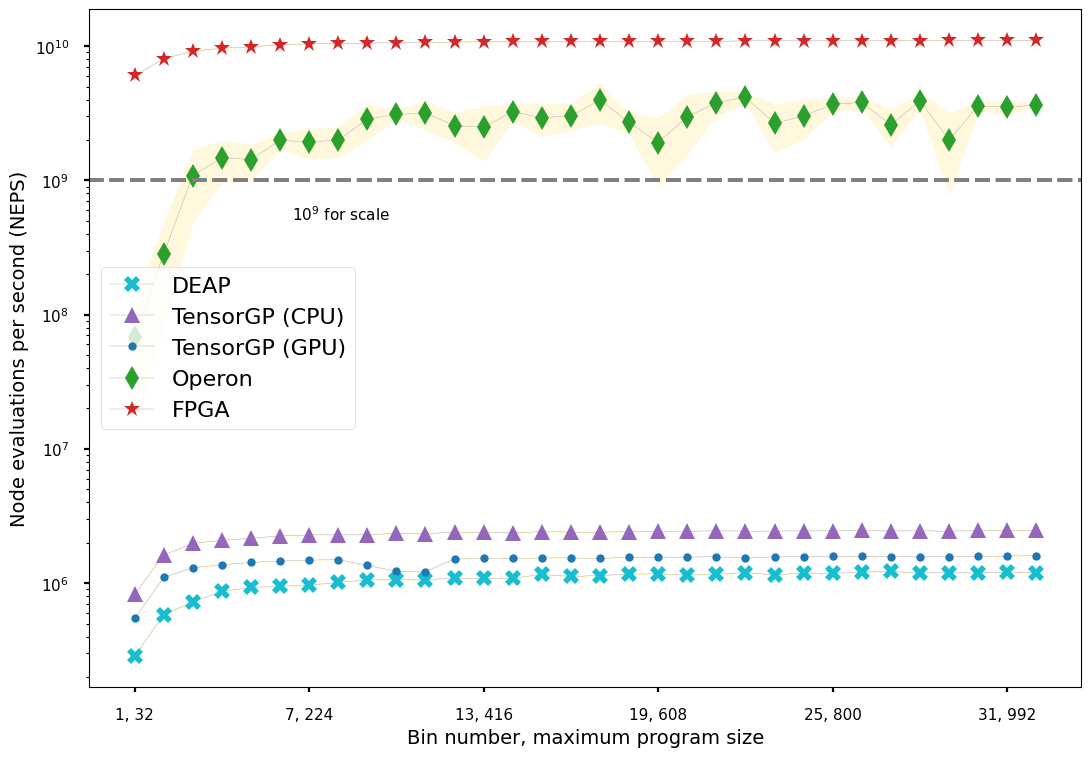

Function set nicolau_a, 100 cases...




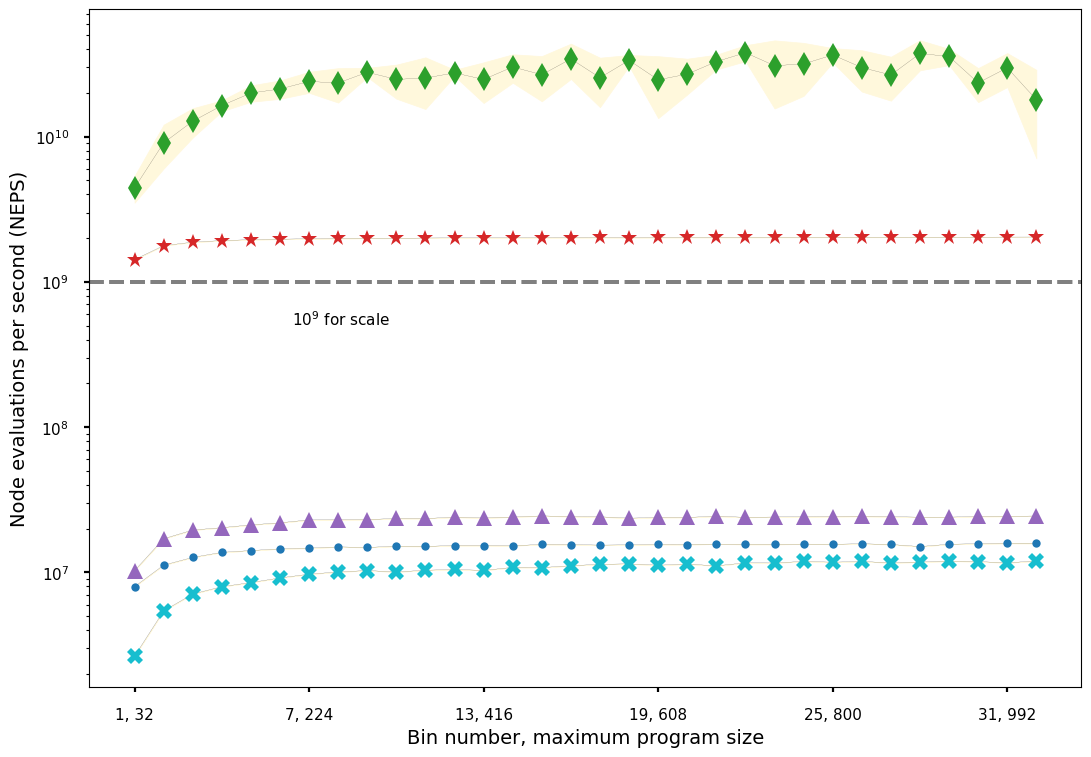

Function set nicolau_a, 1000 cases...




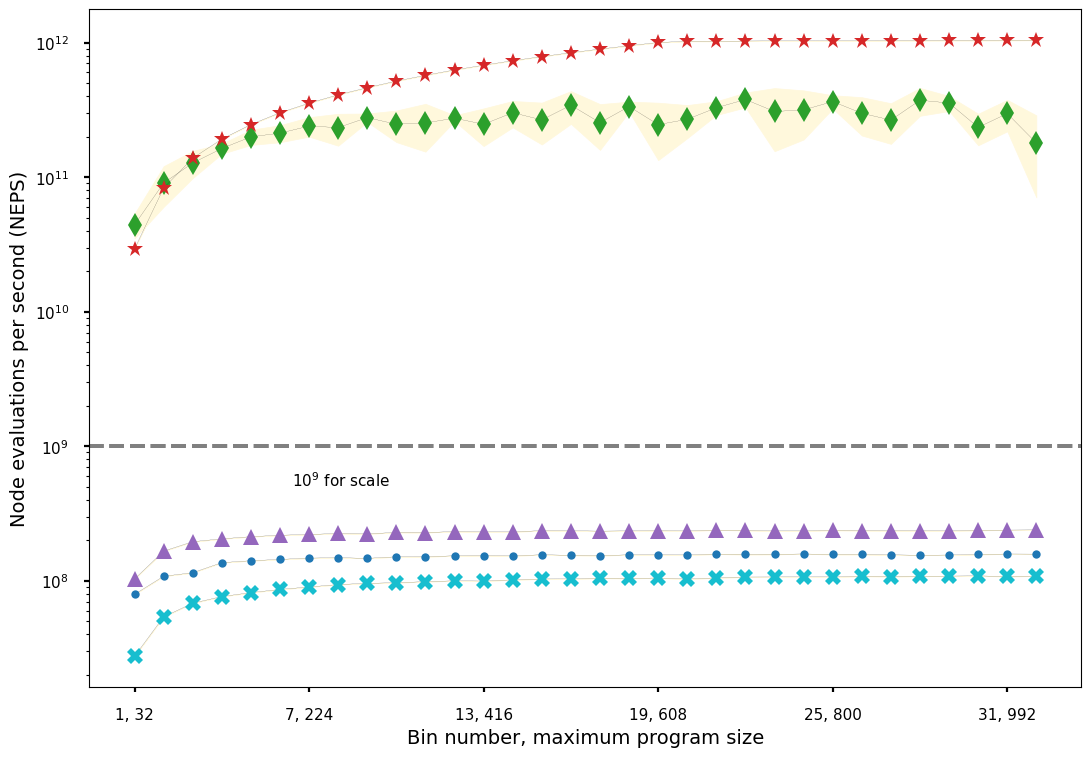

Function set nicolau_a, 10000 cases...




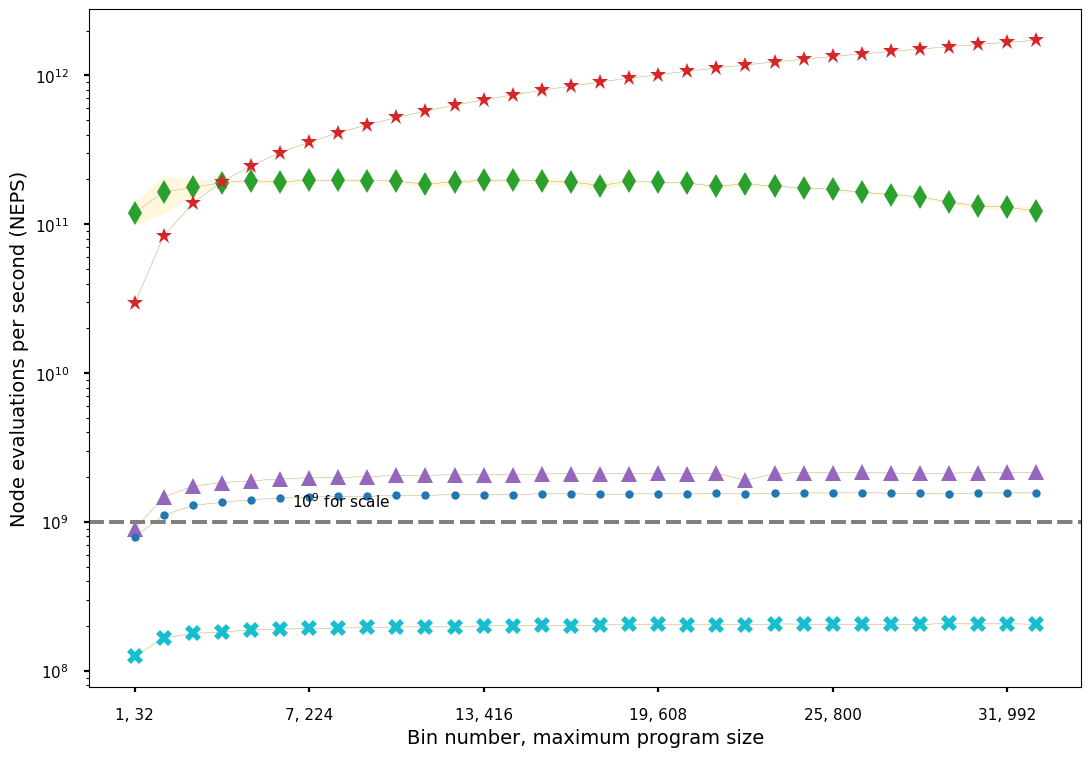

Function set nicolau_a, 100000 cases...




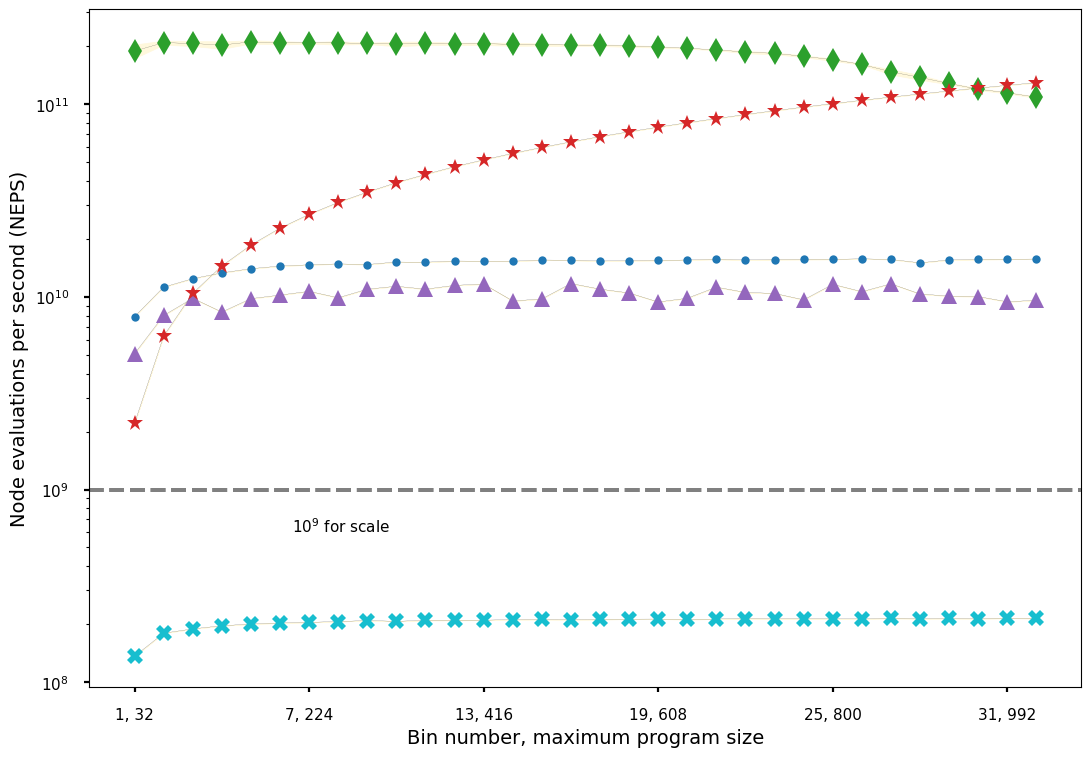

Function set nicolau_b, 10 cases...




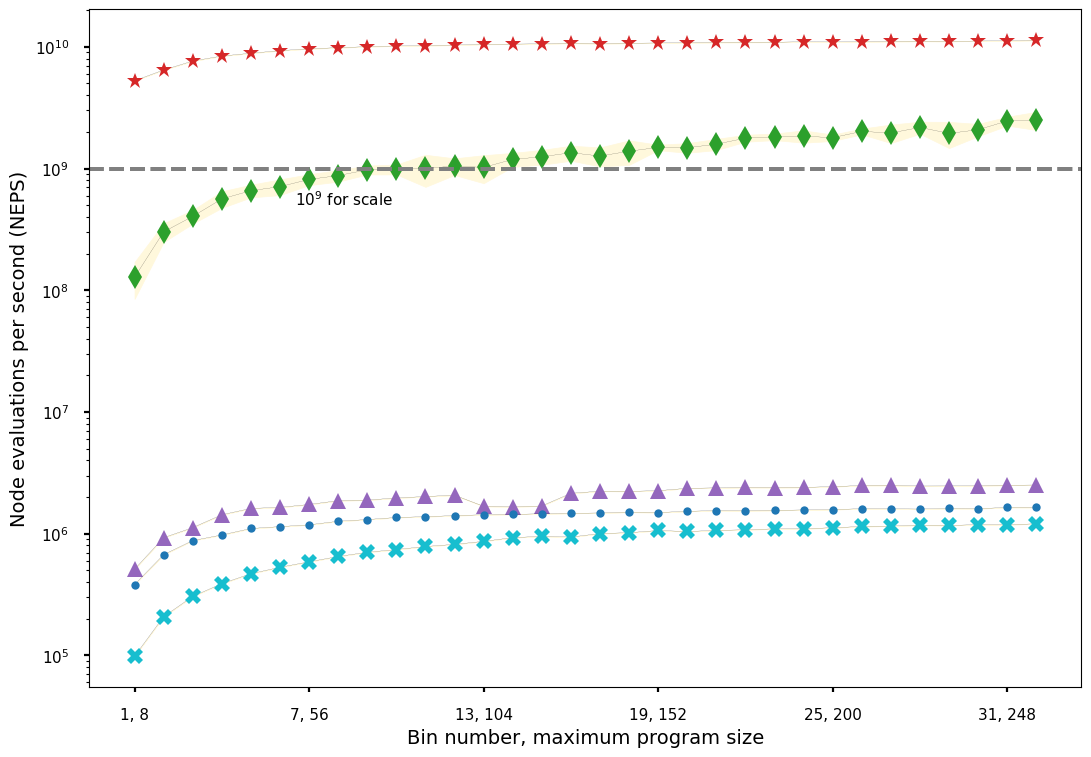

Function set nicolau_b, 100 cases...




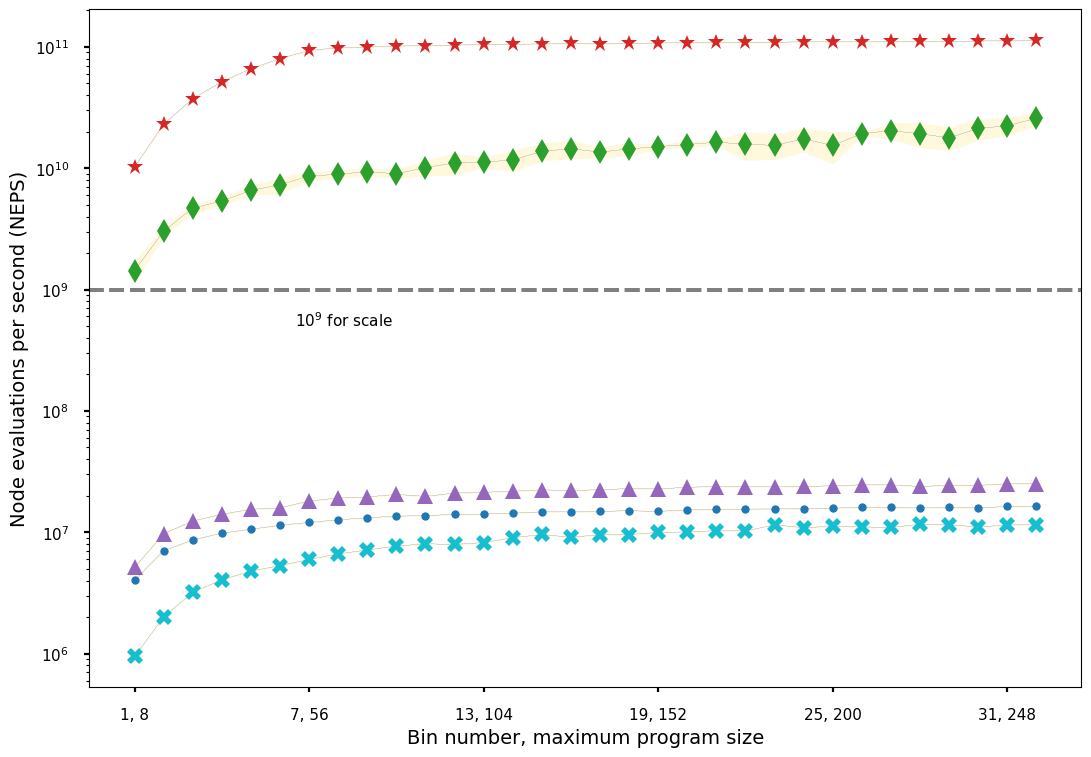

Function set nicolau_b, 1000 cases...




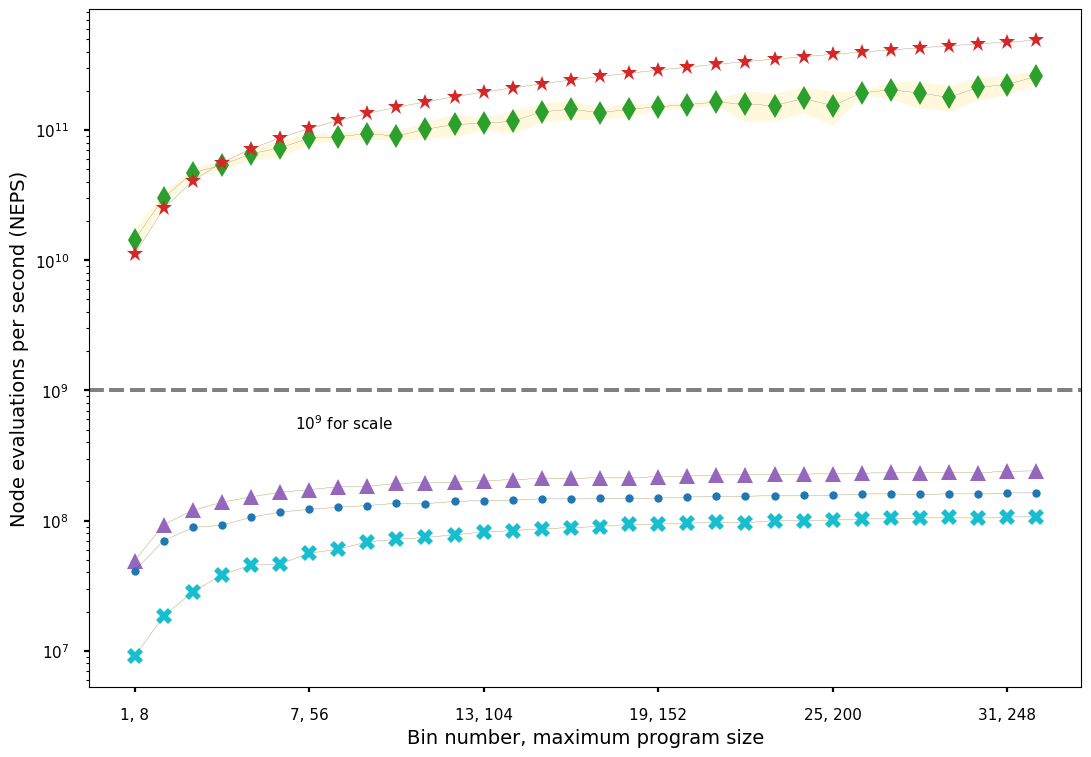

Function set nicolau_b, 10000 cases...




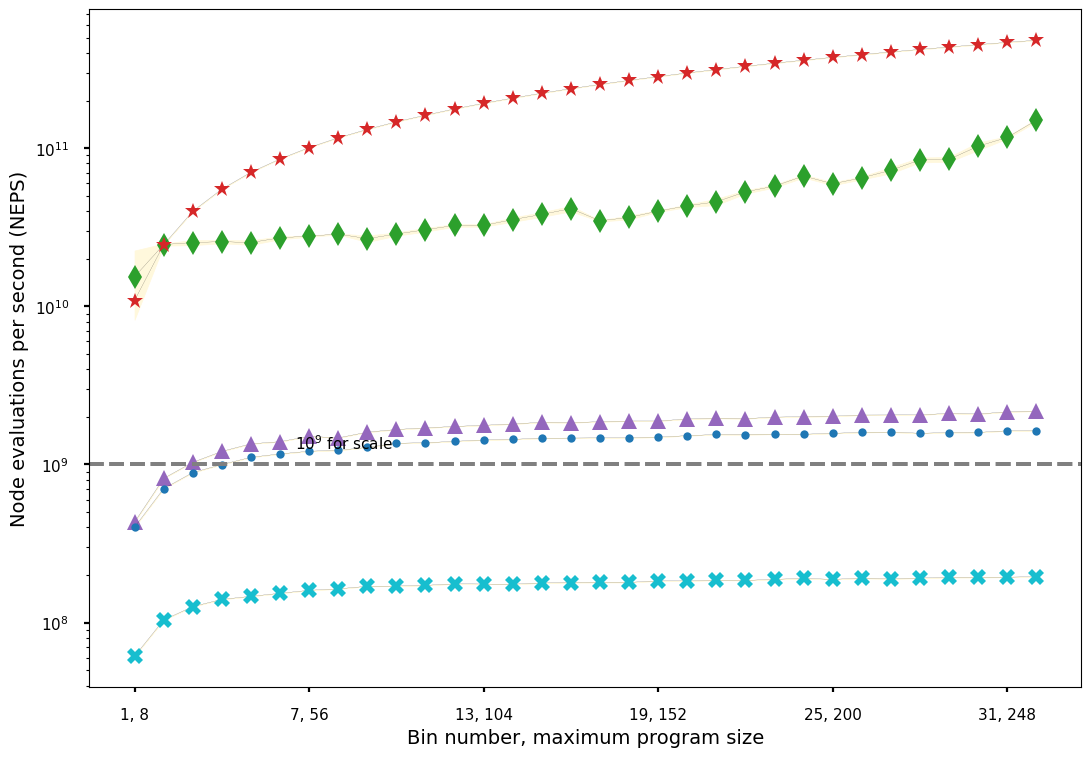

Function set nicolau_b, 100000 cases...




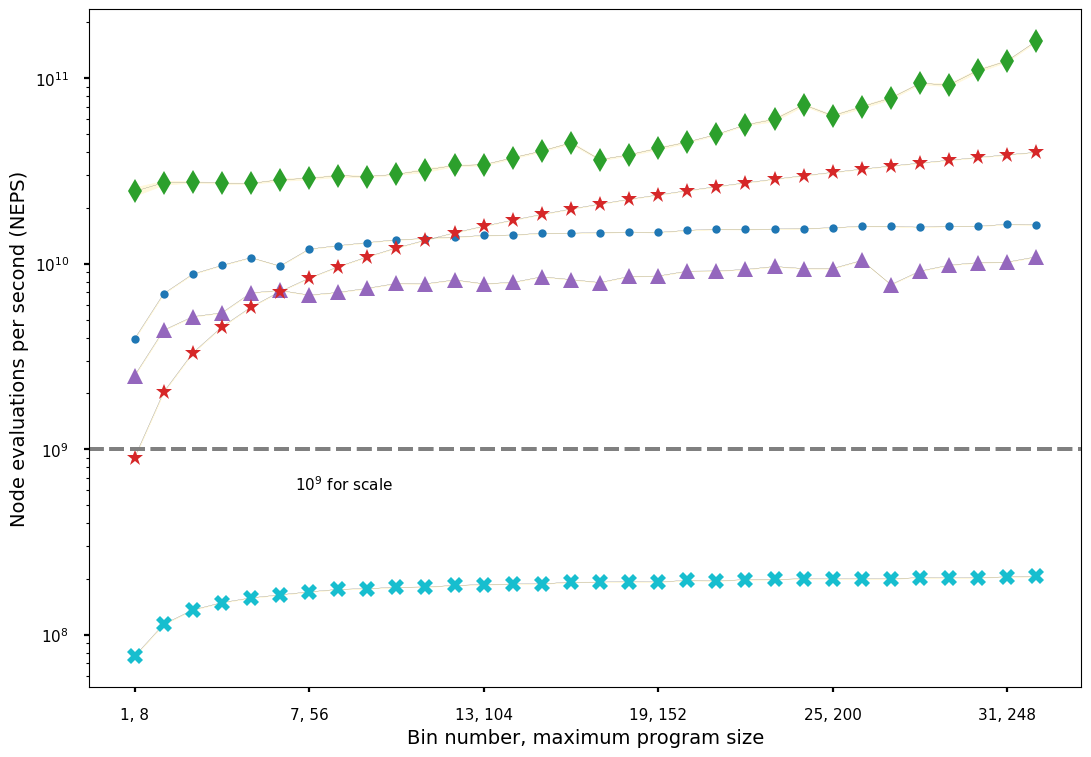

Function set nicolau_c, 10 cases...




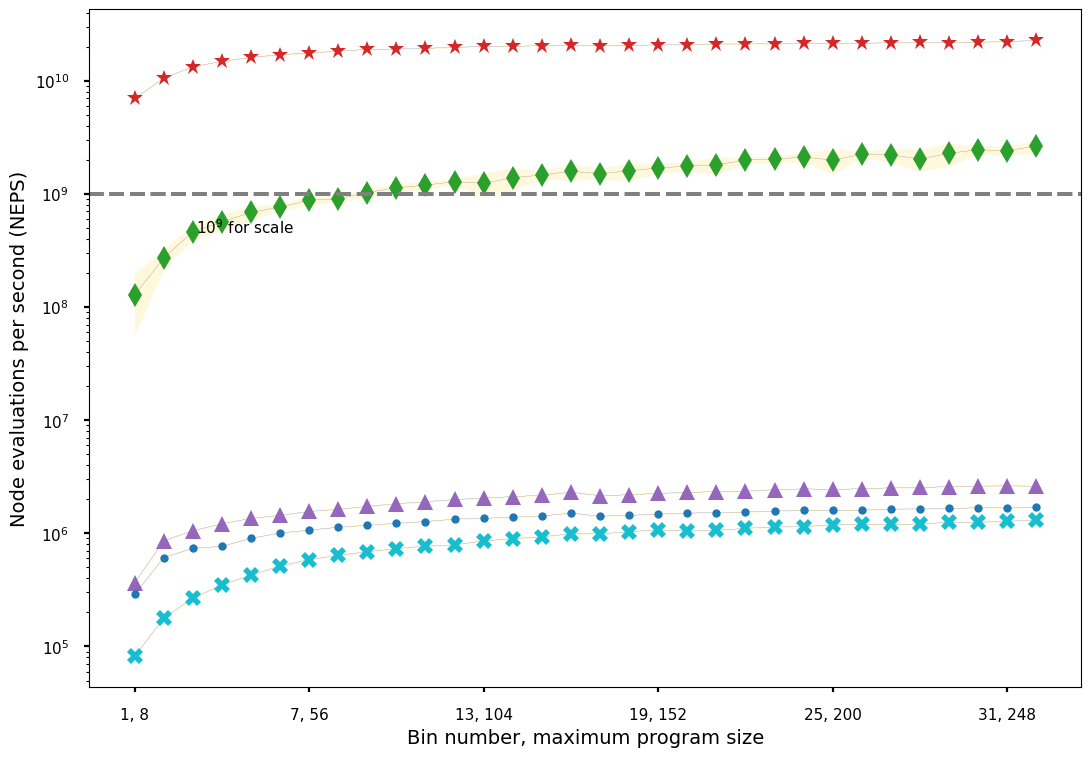

Function set nicolau_c, 100 cases...




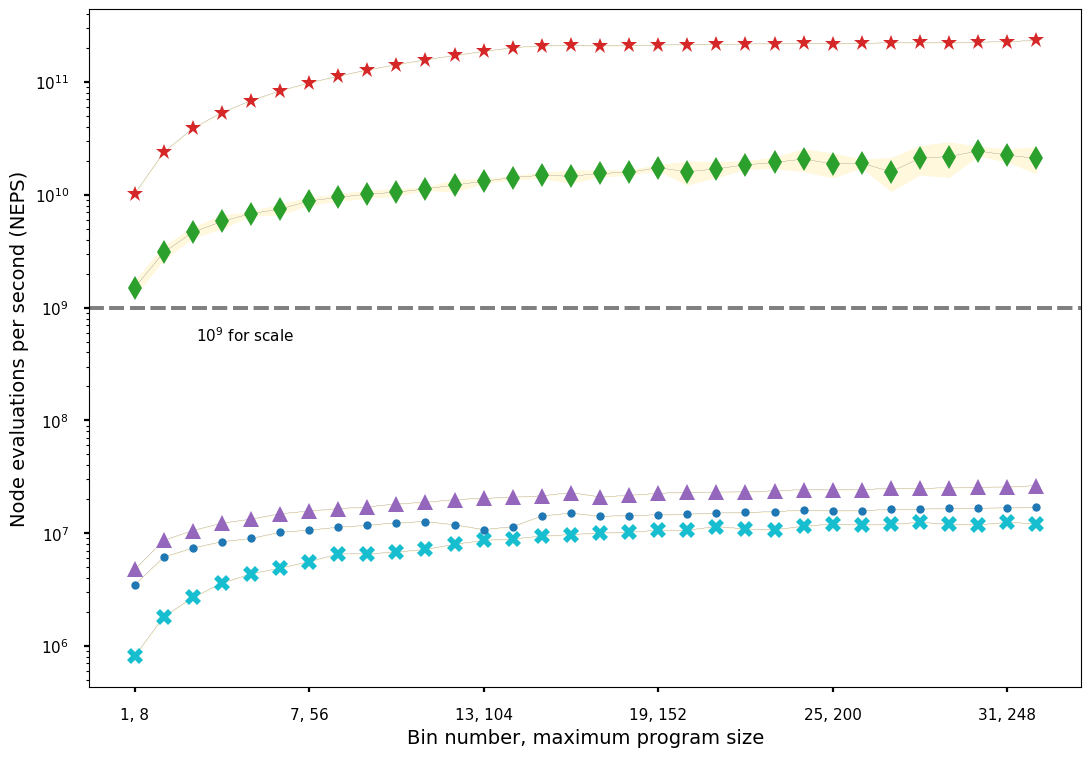

Function set nicolau_c, 1000 cases...




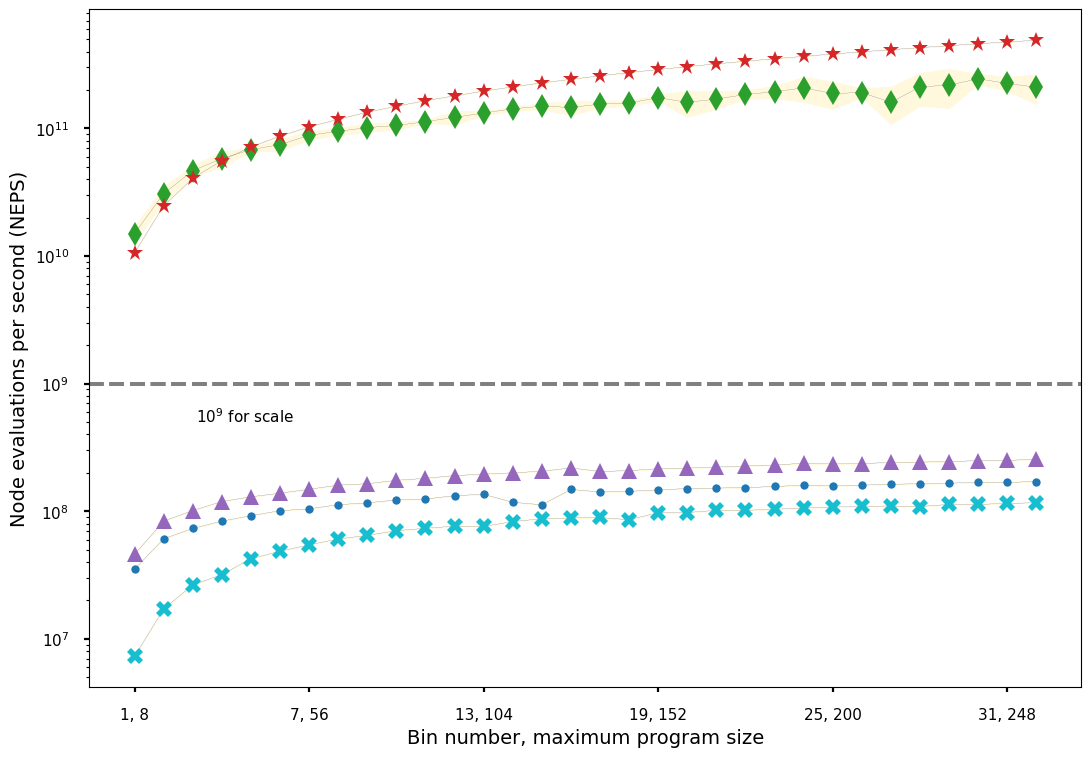

Function set nicolau_c, 10000 cases...




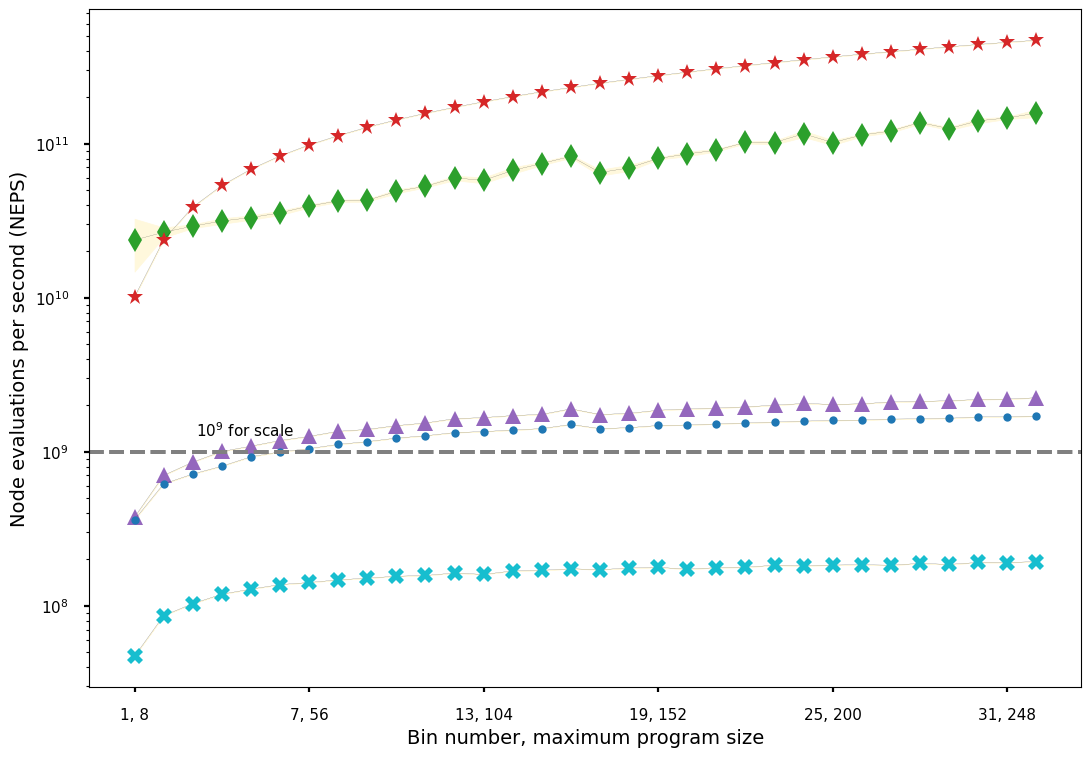

Function set nicolau_c, 100000 cases...




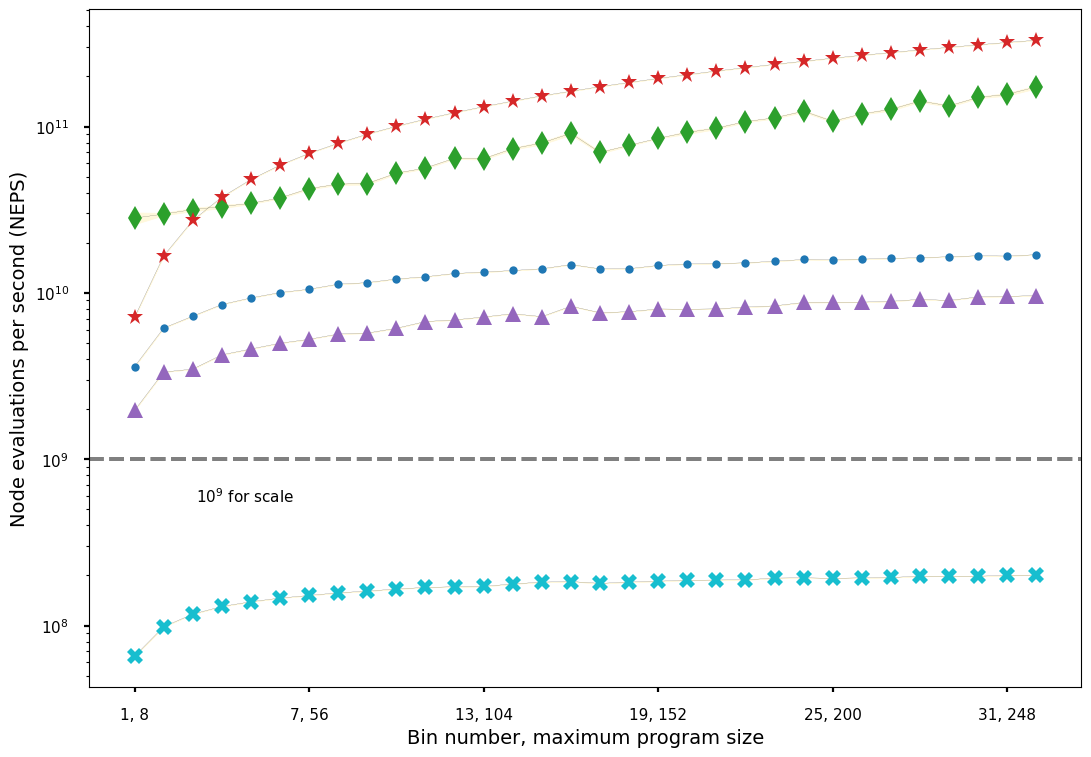

In [11]:
colors = ('tab:cyan', 'tab:purple', 'tab:blue', 'tab:green', 'tab:red')
markers = ('X', '^', '.', 'd', '*')
marker_sizes = (6, 4, 8, 5, 9)
# fill_between = (True, True, True, True, False)
print_legend = ((True, False, False, False, False),
                (False, False, False, False, False),
                (False, False, False, False, False))
# print_function_set = ('nicolau_a', 'nicolau_b')
# print_nfc = (10, 100000)
scale_text_x = ((205, 205, 205, 205, 205),
                (52, 52, 52, 52, 52),
                (25, 25, 25, 25, 25))
scale_text_y = ((0.5e9, 0.5e9, 0.5e9, 1.25e9, 6e8),
                (0.5e9, 0.5e9, 0.5e9, 1.25e9, 6e8),
                (0.45e9, 0.5e9, 0.5e9, 1.25e9, 5.5e8))
                
# median_runtimes = []
average_neps = []
median_neps = []

all_neps = [[], [], [], [], []]

# Plot graph of median node evaluations per second for each tool, 
# for each number of fitness cases, for each function set.
for i, (name, (_, _, max_size, bin_size)) in enumerate(
    function_sets.items()):

    # Prepare for average/median NEPS values for each number 
    # of fitness cases and each tool, for the current function set.
    # average_neps.append([[0]*5]*5)
    # median_neps.append([[0]*5]*5)
    # median_runtimes.append([])
    average_neps.append([])
    median_neps.append([])

    # Number of size bins.
    num_size_bins = int(math.ceil(max_size/bin_size))

    # Index range for plot.
    index = [(bin_size * i) for i in range(1, num_size_bins+1)]
    index_ = [i for i in range(1, num_size_bins+1)]

    for j, nfc in enumerate(num_fitness_cases):
        print(f'Function set {name}, {nfc} cases...\n\n')
        
        # median_runtimes[-1].append([])
        average_neps[-1].append([])
        median_neps[-1].append([])

        for t, tool in enumerate(tools):
            # median_runtimes[-1][-1].append([])
            average_neps[-1][-1].append([])
            median_neps[-1][-1].append([])

            x = index
            y = med_med_neps[t][i][j]
            # t = med_med_avg_runtimes[t][i][j]
            
            iqr = iqr_med_neps[t][i][j]
            lower_bound = [y_ - iqr_ for y_, iqr_ in zip(y, iqr)]
            upper_bound = [y_ + iqr_ for y_, iqr_ in zip(y, iqr)]

            # median_runtimes[-1][-1][-1] = np.median(t)
            average_neps[-1][-1][-1] = np.mean(y)
            median_neps[-1][-1][-1] = np.median(y)

            for neps in y:
                all_neps[t].append(neps)

            plt.plot(
                x, y, label=f'{tool}', markerfacecolor=colors[t], 
                marker=markers[t], markersize=12, color='black', linewidth=0.1)
            plt.axhline(y=1e9, color='gray', linestyle='dashed')
            plt.fill_between(
                x, lower_bound, upper_bound, interpolate=True, 
                color='cornsilk')
            # plt.fill_between(
            #     x, y, where=y<=d, interpolate=True, color='red')


        plt.text(
            scale_text_x[i][j], scale_text_y[i][j], '$10^9$ for scale', 
            weight='normal', fontsize = 11)

        plt.xlabel('Bin number, maximum program size', fontsize=14)
        plt.xticks(index, [f'{str(i_)}, {str(i)}' 
            for i, i_ in zip(index, index_)], fontsize=11)
        plt.yticks(fontsize=11)
        plt.locator_params(axis='x', nbins=6)
        plt.ylabel('Node evaluations per second (NEPS)', fontsize=14)
        plt.yscale('log')
        if print_legend[i][j]:
            plt.legend(loc='center left')
        plt.savefig(f'{graphics_dir}/{name}/median_neps_{nfc}.svg')
        plt.savefig(
            f'{graphics_dir}/{name}/median_neps_{nfc}.png', 
            dpi=600)
        plt.show()

In [ ]:
# Median runtimes for each number of fitness cases,
# for each tool, for each function set.
median_runtimes = []
for t, tool in enumerate(tools):
    median_runtimes.append([])
    for i, _ in enumerate(function_sets.items()):
        median_runtimes[-1].append([])
        for j, nfc in enumerate(num_fitness_cases):
            median_runtimes[-1][-1].append([])
            median_runtimes[-1][-1][-1] = np.median(
                med_med_avg_runtimes[t][i][j])
median_runtimes = np.asarray(median_runtimes)

print(f'Median runtimes:\n{median_runtimes}\n')
print(f'Median runtimes shape:\n{median_runtimes.shape}\n')

# Total median runtimes for each fitness case threshold,
# for each tool.
total_median_runtimes = np.asarray(
    [[np.sum(median_runtimes[t, :, :n+1])
        for n, _ in enumerate(num_fitness_cases)] 
            for t, _ in enumerate(tools)])

print(f'\nTotal median runtimes:\n{total_median_runtimes}\n')
print(f'\nTotal median runtimes shape:\n{total_median_runtimes.shape}\n')

num_nodes = np.asarray(num_nodes)
print(f'\nNum nodes:\n{num_nodes}\n')
print(f'\nNum nodes shape:\n{num_nodes.shape}\n')

# Total number of program nodes across all function sets,
# for each fitness case threshold.
total_nodes = np.asarray(
    [np.sum([fc * num_nodes for fc in num_fitness_cases[:n+1]])
        for n, _ in enumerate(num_fitness_cases)])

print(f'\nTotal nodes:\n{total_nodes}\n')
print(f'\nTotal nodes shape:\n{total_nodes.shape}\n')

# Total median NEPS for each fitness case threshold, for each tool.
total_neps = total_nodes / total_median_runtimes

print(f'\nTotal NEPS:\n{total_neps}\n')
print(f'\nTotal NEPS shape:\n{total_neps.shape}\n')

# Average FPGA speedup for each fitness case threshold.
avg_fpga_speedup = total_neps[-1, :] / total_neps[:-1, :]

print(f'\nAverage FPGA Speedup:\n{avg_fpga_speedup}\n')
print(f'\nAverage FPGA Speedup shape:\n{avg_fpga_speedup.shape}\n')